###  해당 커널은 다음과 같은 프로세스로 진행

1. 데이터 셋 확인
    * 데이터가 어떻게 구성되어 있는지 확인
    * 대부분의 캐글 데이터들은 잘 정제되어 있지만 실제 데이터는 아닐 가능성이 농후
      
    하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정
2. 탐색적 데이터 분석 (EDA, Exploratory Data Analysis)
    * 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인
      
    여러 시각화 툴을 사용하여 insight를 획득
3. 특성 공학 (Feature Engineering)
    * 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 한다.
      
    one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리
4. 모델 개발 및 학습
    * sklearn, keras 을 사용해 모델을 만든다.
    * 파이썬에서 머신러닝을 할 때는 sklearn 을 사용하면 수많은 알고리즘을 일관된 문법으로 사용 가능
    * 또 keras는 딥러닝 개발할 때 모델에 집중할 수 있도록 도움.
    * 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용 가능.
5. 모델 예측 및 평가
    * Train set 을 가지고 모델을 학습시킨 후, Test set 을 가지고 prediction 진행.
   
    그리고 예측 성능이 원하는 수준인지 판단 / 풀려는 문제에 따라 모델을 평가하는 방식도 달라진다.

In [68]:
from scipy.stats import norm
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import os
import joblib
import configparser


## ignore warnings
import warnings
warnings.filterwarnings('ignore')

## matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 
## 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편하다.
plt.style.use('ggplot')
sns.set_theme(font_scale=1.3) 


import missingno as msno
%matplotlib inline

##### 1. 데이터셋 확인

In [69]:
class Data_Preprocess:
    """
    class: Data_preprocess for ML
    1) Based on config file, server, ID, password, DB, case
    """
   
    ### 초기화 및 config 파일 읽어오기.
    def __init__(self, case):
        config = configparser.ConfigParser()
        config.read('AOP_config.cfg')
        
        self.server = config["server address"]["address"]
        self.ID = config["username"]["ID"]
        self.password = config["password"]["PW"]
        self.list_DBs = config["database"]["name"].split(',')
        self.export_DB = config["export database"]["name"]
        self.case = case
        
            
    ### MS-SQL로부터 데이터 가져오기.
    def _sql_get(self):
        print(self.server)
        if self.case == 'model_fit':
            sel_database = self.list_DBs
            
        else:
            sel_database = [self.export_DB]
        print(sel_database)
            
        list_df = []
        for database in sel_database:
            print('---------------')
            print('connect:', database)
            conn = pyodbc.connect(f'DRIVER={{SQL Server}};'
                                  f'SERVER={self.server};'
                                  f'DATABASE={database};'
                                  f'UID={self.ID};'
                                  f'PWD={self.password}')
                
            query = f'''
                        SELECT
                        a.[temperatureId]
                        ,a.[probeId]
                        ,a.[tempSSId]
                        ,a.[measDate]
                        ,a.[measSetNum]
                        ,a.[roomTempC]
                        ,a.[pulseVoltage]
                        ,a.[temperatureC]
                        ,a.[numTxCycles]
                        ,a.[numTxElements]
                        ,a.[txFrequencyHz]
                        ,a.[elevAperIndex]
                        ,a.[isTxAperModulationEn]
                        ,a.[txpgWaveformStyle]
                        ,a.[pulseRepetRate]
                        ,a.[scanRange]
                        ,b.[probeName]
                        ,b.[probePitchCm]
                        ,b.[probeRadiusCm]
                        ,b.[probeElevAperCm0]
                        ,b.[probeElevAperCm1]
                        ,b.[probeNumElements]
                        ,b.[probeElevFocusRangCm] 
                        ,b.[probeDescription]
                        FROM temperature AS a
                        LEFT JOIN probe_geo AS b
                            ON a.[probeId] = b.[probeId]
                        where (a.probeId < 99999999 and a.probeId > 100) and (a.measSetNum = 3 or a.measSetNum = 4)  
                        ORDER BY 1
                        '''
                    
            Raw_data = pd.read_sql_query(sql=query, con = conn)
            Raw_data.insert(0, "Database", f'{database}', True) ## allow_duplicate(중복 삽입 허용) True 설정
            
            print('Data 갯수:', len(Raw_data.index))
            list_df.append(Raw_data)
    
        AOP_data = pd.concat(list_df)
        
        ## 누락된 데이터 삭제 -> probeNumElements를 기준으로 데이터가 누락되어 있으면 전체 열을 삭제.
        AOP_data = AOP_data.dropna(subset=['probeNumElements'])
        
        return AOP_data

In [70]:
if __name__ == '__main__':
    DPP = Data_Preprocess(case='model_fit')
    AOP_data = DPP._sql_get()

kr001s1804srv
['Griffin_r01', 'Frosk_r03', 'New_Trees', 'LEO_4port_r01_AutoReport', 'FROSK_r01_AutoReport', 'FROSK_r02_new']
---------------
connect: Griffin_r01


Data 갯수: 3229
---------------
connect: Frosk_r03
Data 갯수: 875
---------------
connect: New_Trees
Data 갯수: 352
---------------
connect: LEO_4port_r01_AutoReport
Data 갯수: 1221
---------------
connect: FROSK_r01_AutoReport
Data 갯수: 491
---------------
connect: FROSK_r02_new
Data 갯수: 118


---
### 2. 탐색적 데이터 분석(EDA)
   #### 1) 데이터 확인
   - Printing first 5 rows of the train dataset.

In [71]:
AOP_data.head()

,Database,temperatureId,probeId,tempSSId,measDate,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,...,pulseRepetRate,scanRange,probeName,probePitchCm,probeRadiusCm,probeElevAperCm0,probeElevAperCm1,probeNumElements,probeElevFocusRangCm,probeDescription
0,Griffin_r01,325,11268278,147,2016-08-10,4,22.299999,34.899807,34.000000,2.0,...,2687.000000,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
1,Griffin_r01,327,11268278,147,2016-08-10,4,22.400000,44.226025,35.099998,2.0,...,1810.520020,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
2,Griffin_r01,329,11268278,147,2016-08-10,4,22.799999,56.044472,36.299999,2.0,...,1219.949951,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
3,Griffin_r01,332,11268278,147,2016-08-10,4,23.000000,71.021141,37.599998,2.0,...,822.010010,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
4,Griffin_r01,334,11268278,147,2016-08-10,4,23.100000,90.000000,38.799999,2.0,...,553.880005,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex


In [72]:
## AOP_data 데이터프레임 파라미터 확인.
AOP_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5896 entries, 0 to 117
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Database              5896 non-null   object        
 1   temperatureId         5896 non-null   int64         
 2   probeId               5896 non-null   int64         
 3   tempSSId              5896 non-null   int64         
 4   measDate              5896 non-null   datetime64[ns]
 5   measSetNum            5896 non-null   int64         
 6   roomTempC             5896 non-null   float64       
 7   pulseVoltage          5896 non-null   float64       
 8   temperatureC          5896 non-null   float64       
 9   numTxCycles           5896 non-null   float64       
 10  numTxElements         5896 non-null   int64         
 11  txFrequencyHz         5896 non-null   float64       
 12  elevAperIndex         5896 non-null   int64         
 13  isTxAperModulationEn  58

---
#### 2) Null 데이터 확인

In [73]:
print(AOP_data.isnull().sum())

## 백분율로 변환하여 display
round(AOP_data.isnull().sum()/len(AOP_data) * 100, 2)

Database                   0
temperatureId              0
probeId                    0
tempSSId                   0
measDate                   0
measSetNum                 0
roomTempC                  0
pulseVoltage               0
temperatureC               0
numTxCycles                0
numTxElements              0
txFrequencyHz              0
elevAperIndex              0
isTxAperModulationEn       0
txpgWaveformStyle          0
pulseRepetRate             0
scanRange                  0
probeName                  0
probePitchCm               0
probeRadiusCm            830
probeElevAperCm0           0
probeElevAperCm1        5896
probeNumElements           0
probeElevFocusRangCm       0
probeDescription           0
dtype: int64


Database                  0.00
temperatureId             0.00
probeId                   0.00
tempSSId                  0.00
measDate                  0.00
measSetNum                0.00
roomTempC                 0.00
pulseVoltage              0.00
temperatureC              0.00
numTxCycles               0.00
numTxElements             0.00
txFrequencyHz             0.00
elevAperIndex             0.00
isTxAperModulationEn      0.00
txpgWaveformStyle         0.00
pulseRepetRate            0.00
scanRange                 0.00
probeName                 0.00
probePitchCm              0.00
probeRadiusCm            14.08
probeElevAperCm0          0.00
probeElevAperCm1        100.00
probeNumElements          0.00
probeElevFocusRangCm      0.00
probeDescription          0.00
dtype: float64

---
- Null data 시각화
    - probeRadiusCm / probeEleAperCm1** 누락 데이터 발견 및 앞으로 해당 parameter 어떻게 할 지 계획  

<Axes: >

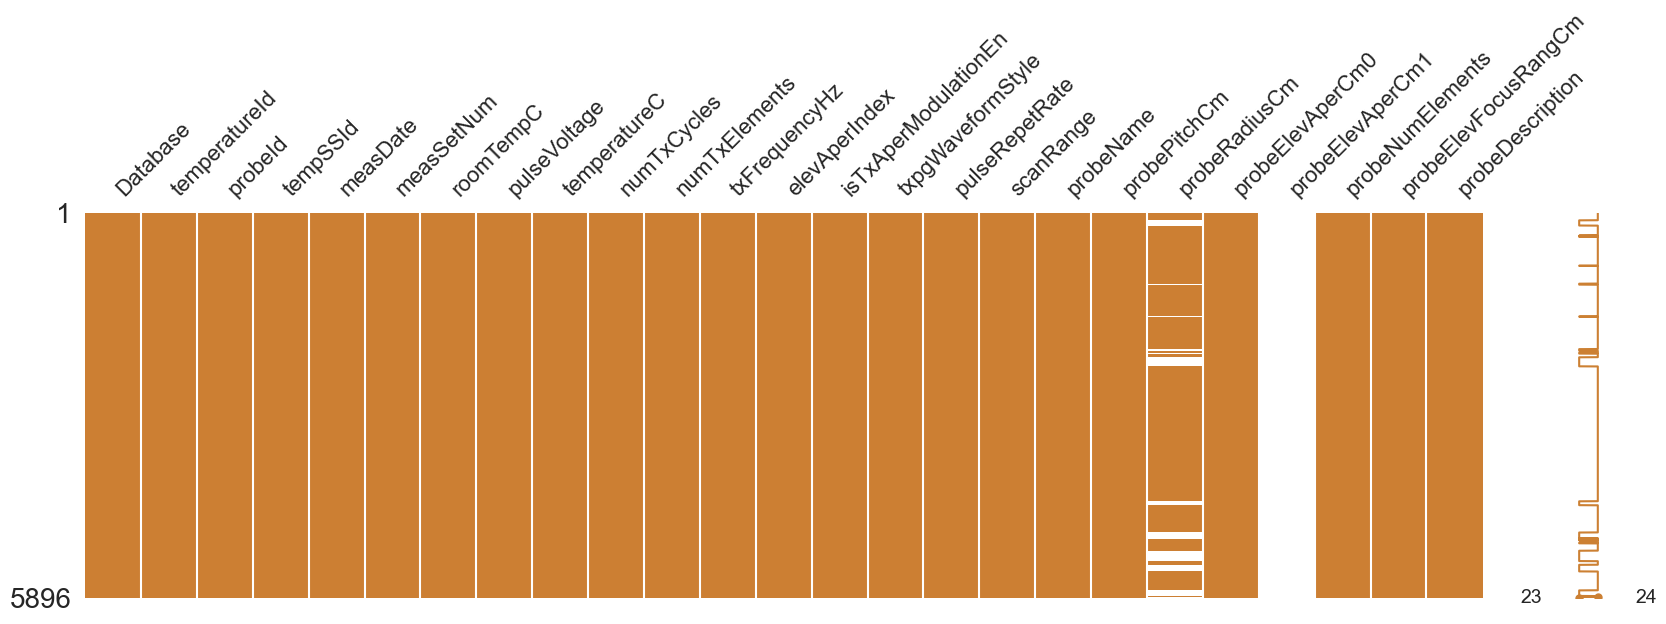

In [74]:
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### 3) 데이터 parameter 전략을 어떻게 가지고 갈 것 인지?
- a) probeRadiusCm [NULL] 데이터 --> [0]으로 변경
- b) probeElevAperCm1 컬럼 데이터 전부 삭제 --> 전부 NULL 데이터이기에 삭제
- c) probeDescription 명확하게 구분화
      - Curved, Convex, Linear, Phased
- d) measDate는 필요없어 보임
- e) probeName 역시 필요없어 보임 --> probeId로 대체
- f) Target 데이터에 대한 고민이 필요해 보임.
      - temperatureC
      - roomTempC

---
#### a) probeRadiusCm: [NULL] 데이터는 0으로 변경

<Axes: >

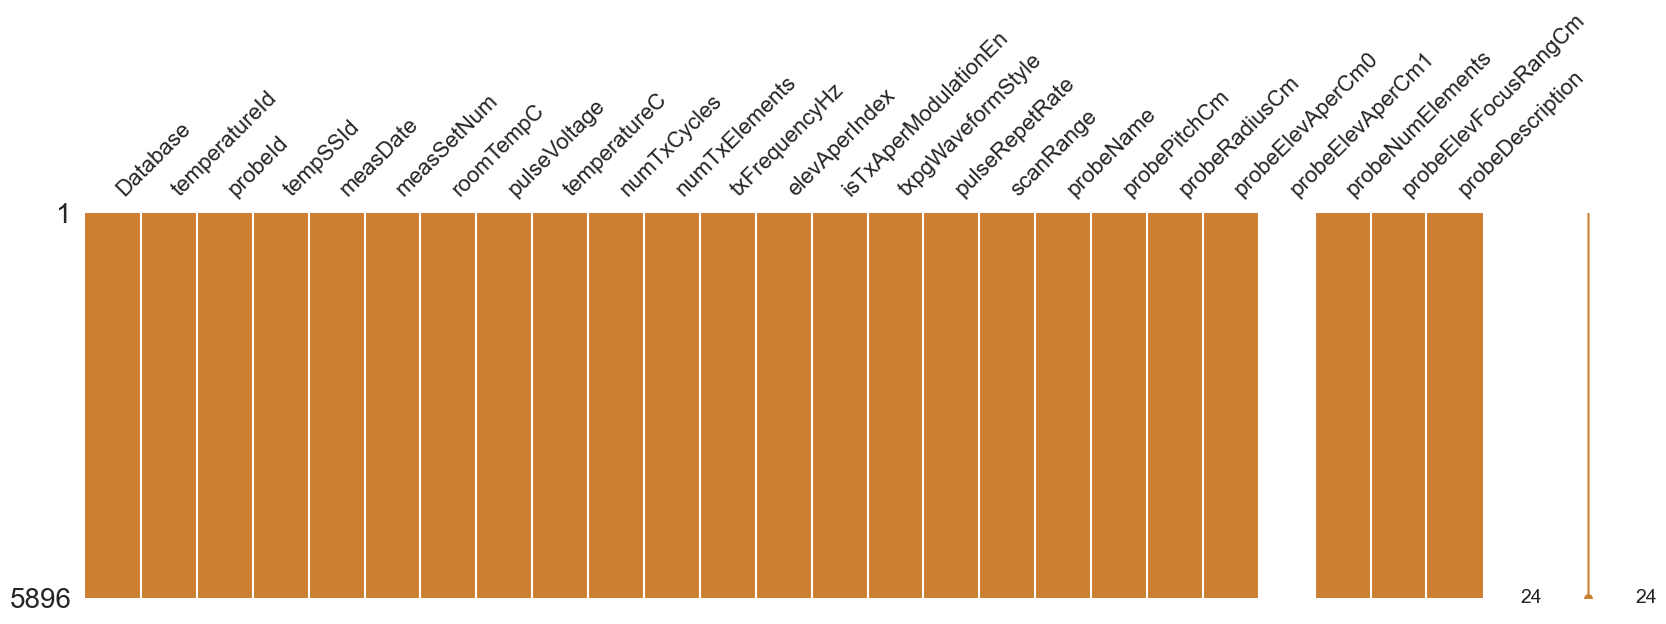

In [75]:
AOP_data['probeRadiusCm'].fillna(0, inplace=True)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### b) Drop(All NULL 데이터) --> probeElevAperCm1

<Axes: >

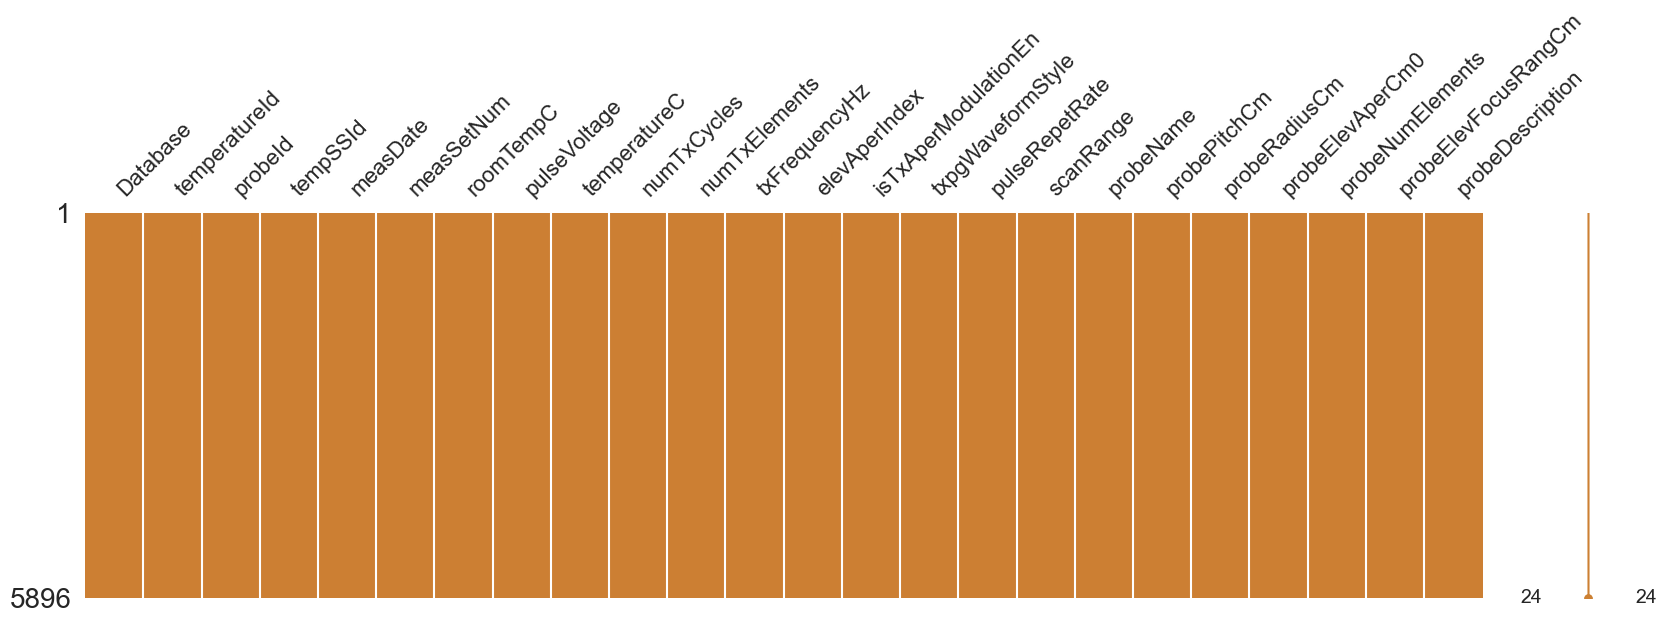

In [76]:
AOP_data = AOP_data.drop('probeElevAperCm1', axis=1)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### c) probeDescription 구분을 명확하게

In [77]:
# 열의 데이터 종류 및 갯수 확인
column_name = 'probeDescription'  # 확인하고자 하는 열의 이름
unique_values = AOP_data[column_name].unique()
value_counts = AOP_data[column_name].value_counts()

print(f"{column_name} 열의 데이터 종류: {unique_values}")
print(f"{column_name} 열의 각 데이터 갯수:\n{value_counts}")

probeDescription 열의 데이터 종류: ['Convex' 'Phased' 'Curved' 'Linear' 'AcuNav_Phased' 'Phase']
probeDescription 열의 각 데이터 갯수:
probeDescription
Convex           1809
Linear           1513
Curved           1257
Phased           1044
Phase             169
AcuNav_Phased     104
Name: count, dtype: int64


In [78]:
AOP_data.loc[AOP_data["probeDescription"] == "Curved", "probeDescription"] = "Convex"
AOP_data.loc[AOP_data["probeDescription"] == "Phased", "probeDescription"] = "Phase"
AOP_data.loc[AOP_data["probeDescription"] == "AcuNav_Phased", "probeDescription"] = "Phase"

# 열의 데이터 종류 및 갯수 확인
column_name = 'probeDescription'  # 확인하고자 하는 열의 이름
unique_values = AOP_data[column_name].unique()
value_counts = AOP_data[column_name].value_counts()

print(f"{column_name} 열의 데이터 종류: {unique_values}")
print(f"{column_name} 열의 각 데이터 갯수:\n{value_counts}")
print(len(AOP_data[column_name]))

probeDescription 열의 데이터 종류: ['Convex' 'Phase' 'Linear']
probeDescription 열의 각 데이터 갯수:
probeDescription
Convex    3066
Linear    1513
Phase     1317
Name: count, dtype: int64
5896


---
#### d)-e) measDate / probeName 필요없어서 Drop

<Axes: >

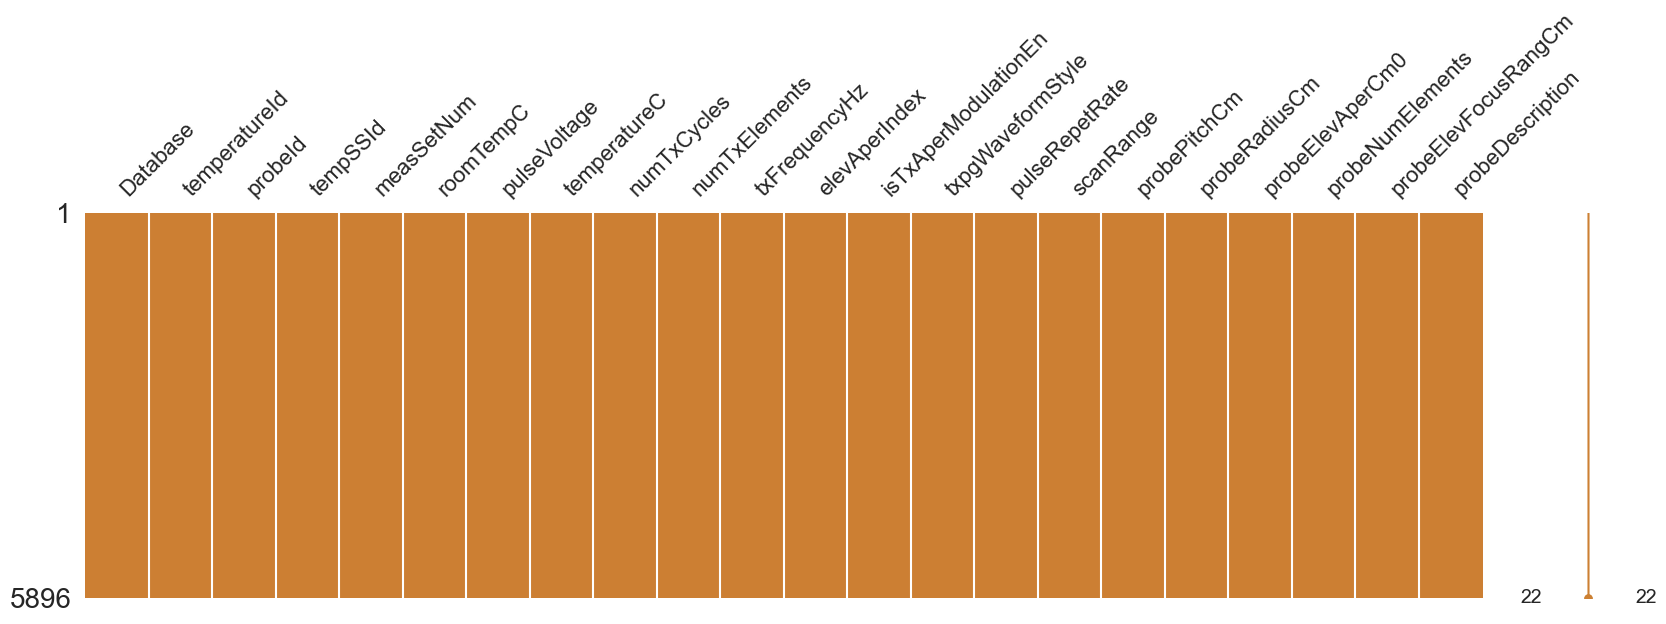

In [79]:
AOP_data = AOP_data.drop(["measDate", "probeName"], axis=1)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### f) Target 데이터 분석

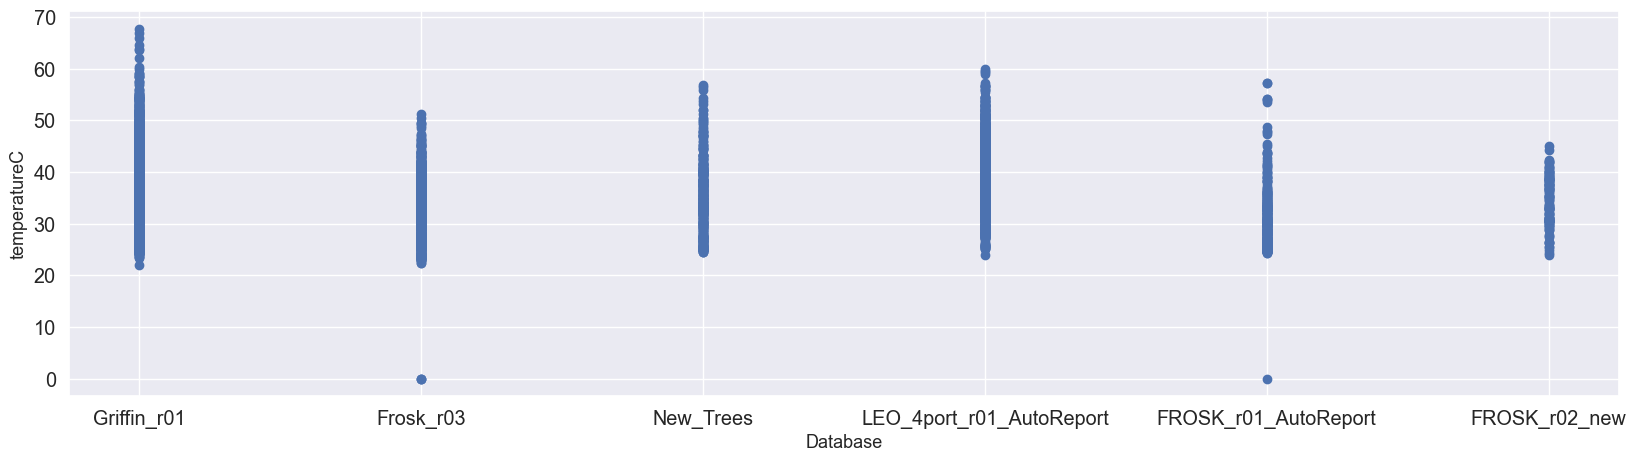

In [80]:
fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x = AOP_data['Database'], y = AOP_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

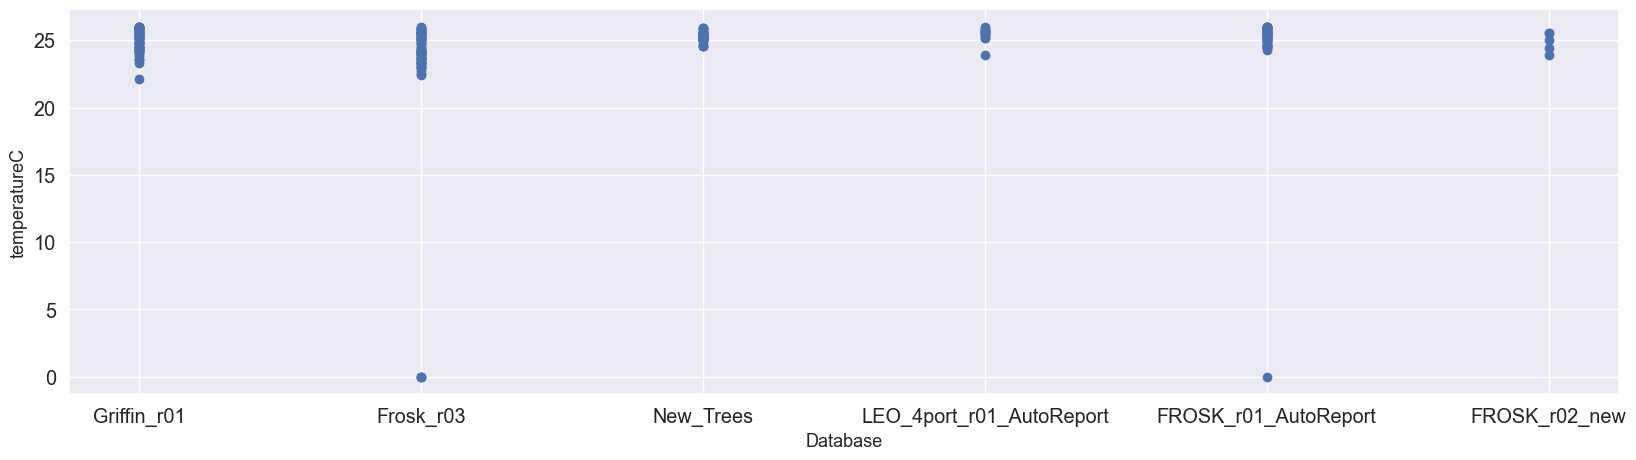

In [81]:
# temperatureC가 26도 이하인 데이터만 필터링
filtered_data = AOP_data[AOP_data['temperatureC'] <= 26]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=filtered_data['Database'], y=filtered_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

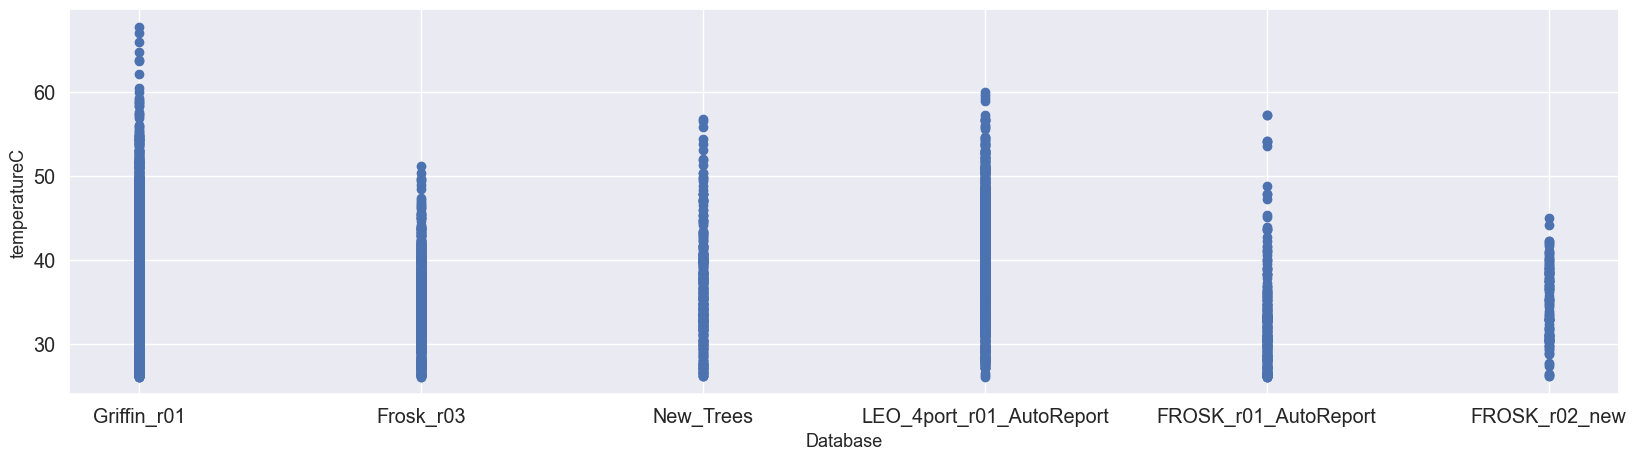

In [82]:
# temperatureC가 26도 이상인 행만 선택
AOP_data = AOP_data[AOP_data['temperatureC'] > 26]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=AOP_data['Database'], y=AOP_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

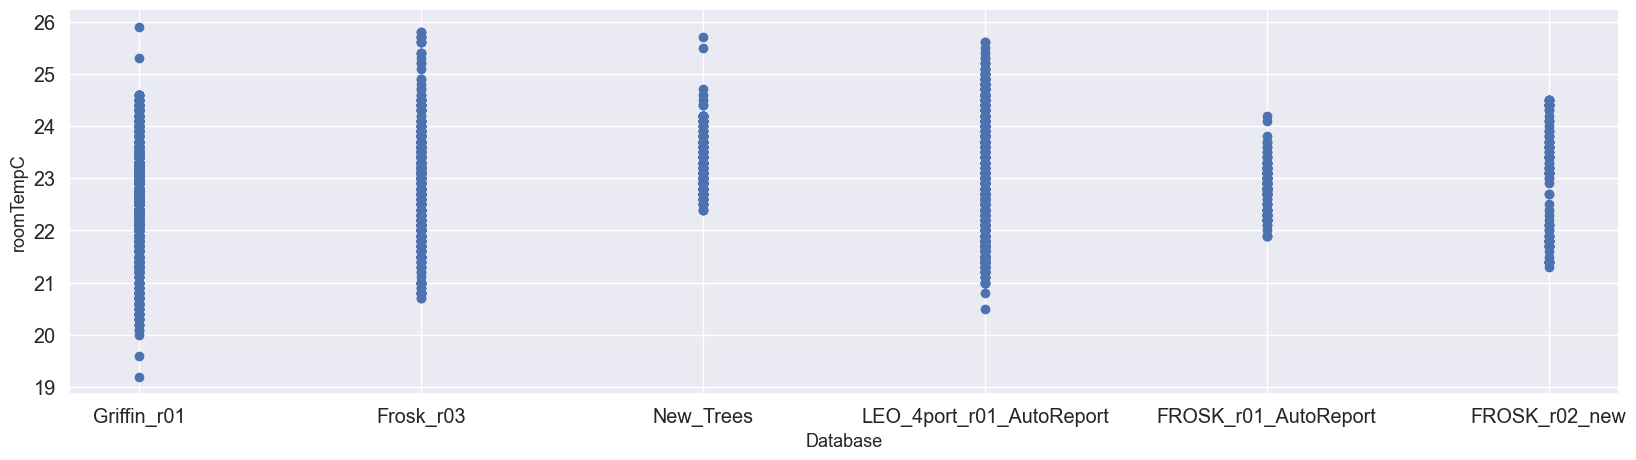

In [83]:
AOP_data = AOP_data[AOP_data['roomTempC'] < 26]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=AOP_data['Database'], y=AOP_data['roomTempC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('roomTempC', fontsize=13)
plt.show()

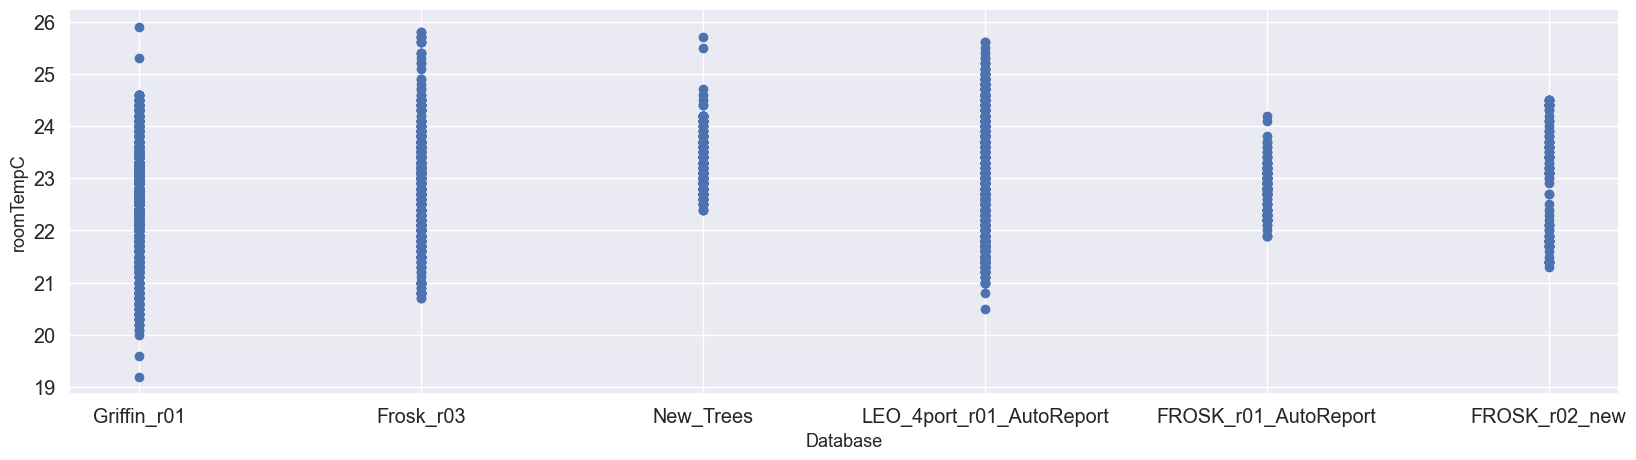

In [84]:
AOP_data = AOP_data[AOP_data['roomTempC'] > 18]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=AOP_data['Database'], y=AOP_data['roomTempC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('roomTempC', fontsize=13)
plt.show()

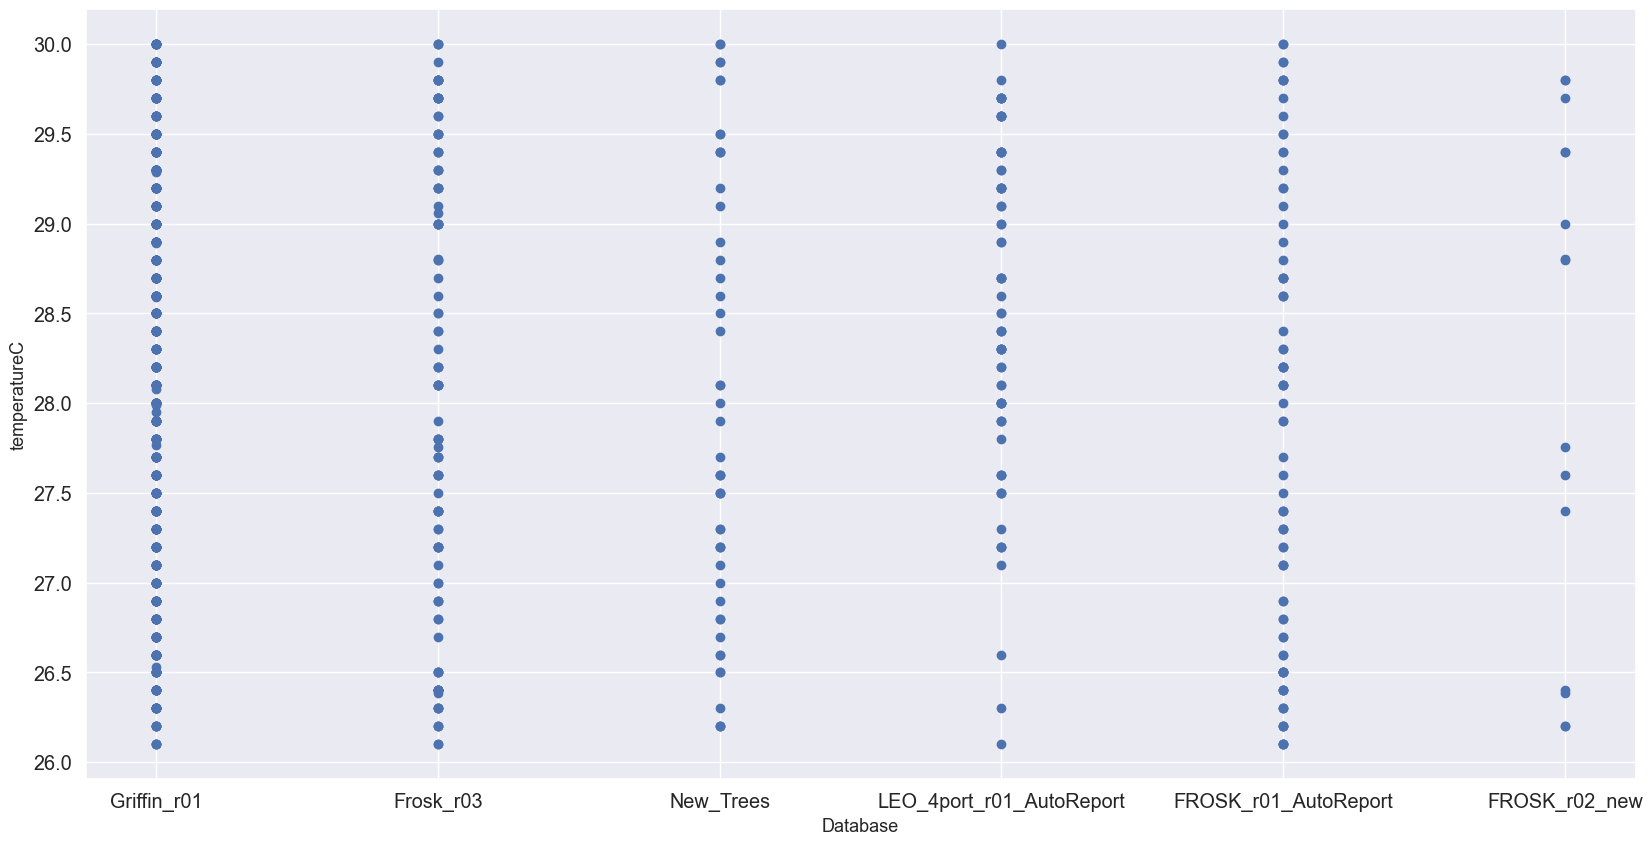

In [85]:
# temperatureC가 26도 이하인 데이터만 필터링
filtered_data = AOP_data[AOP_data['temperatureC'] <= 30]

fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x=filtered_data['Database'], y=filtered_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

---
#### f) Target 데이터의 분석
- temperatureC - roomTempC 분석
- histogram이용하여 분석
- Skewness / 왜도
    - symmetrical bell curve 혹은 normal distribution에서 왜곡 정도를 말한다. 데이터 분포의 대칭성이 얼마나 결핍되었는지를 측정한다. 완전히 대칭인 분포는 skewness가 0이다.
    - 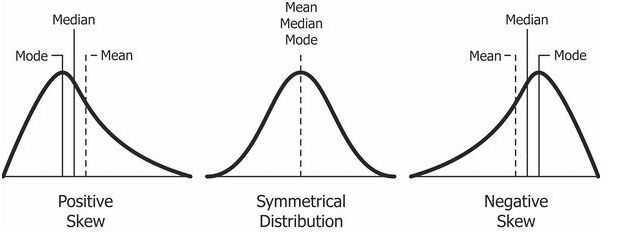

---
#### 확률 및 분포

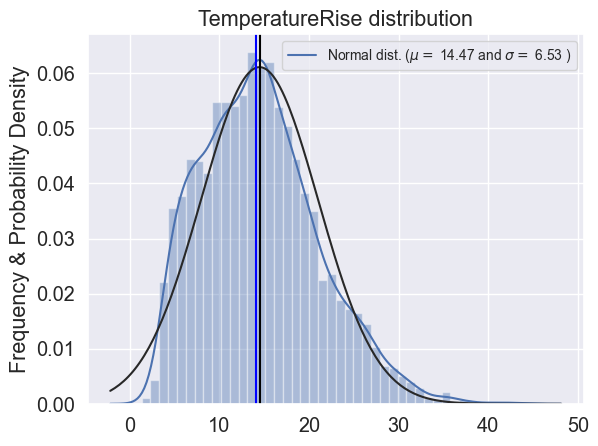

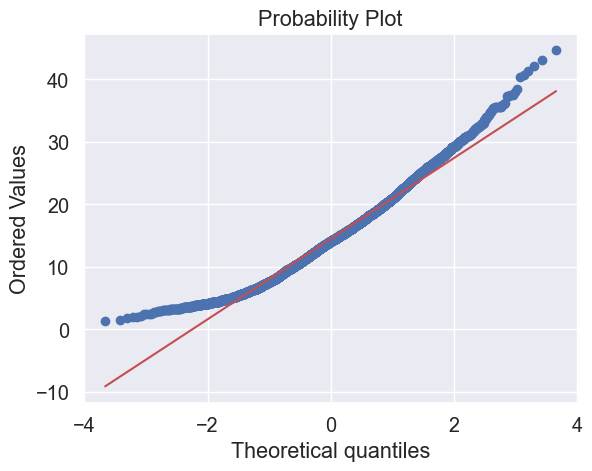

Skewness & TempRise: 0.574438
Kurtosis & TempRise: 0.218620


In [86]:
TemperatureRise = (AOP_data['temperatureC'] - AOP_data['roomTempC'])

sns.distplot(TemperatureRise , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(TemperatureRise)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Frequency & Probability Density')
plt.title('TemperatureRise distribution')

## TemperatureRise mean and median value display
plt.axvline(TemperatureRise.mean(), color='black')
plt.axvline(TemperatureRise.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(TemperatureRise, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & TempRise: %f" % TemperatureRise.skew())
print("Kurtosis & TempRise: %f" % TemperatureRise.kurt())

---
#### Temperature 분석

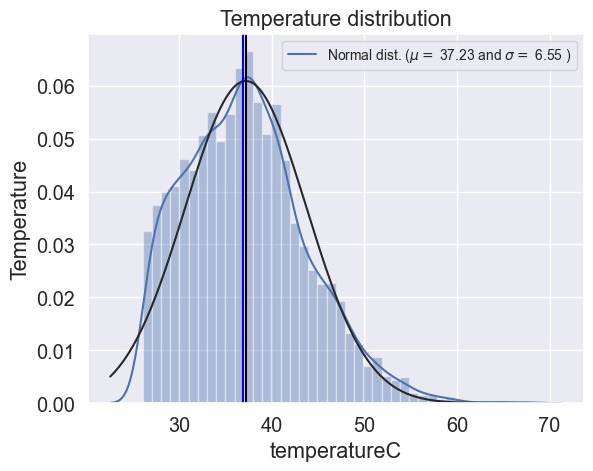

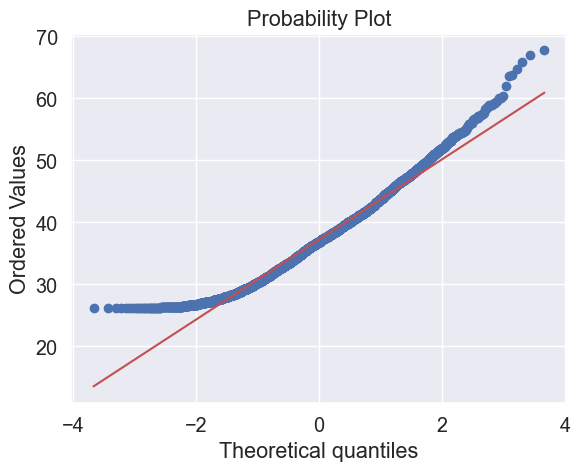

Skewness & Temp: 0.556894
Kurtosis & Temp: 0.219811


In [87]:
Temperature = (AOP_data['temperatureC'])

sns.distplot(Temperature , fit=norm);

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Temperature)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Temperature')
plt.title('Temperature distribution')

## Temperature mean and median value display
plt.axvline(Temperature.mean(), color='black')
plt.axvline(Temperature.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Temperature, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % Temperature.skew())
print("Kurtosis & Temp: %f" % Temperature.kurt())

---
#### log transform 변환하여 확인하기(TemperatureRise)

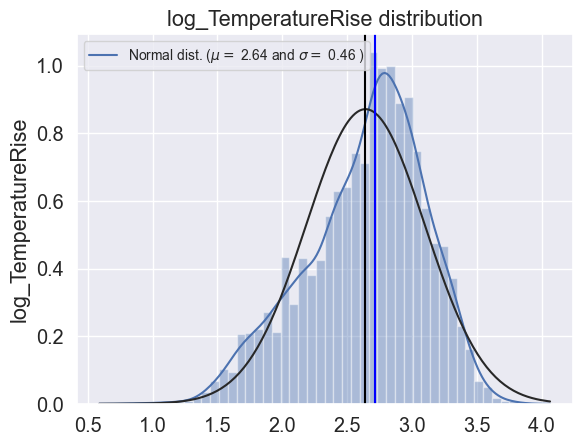

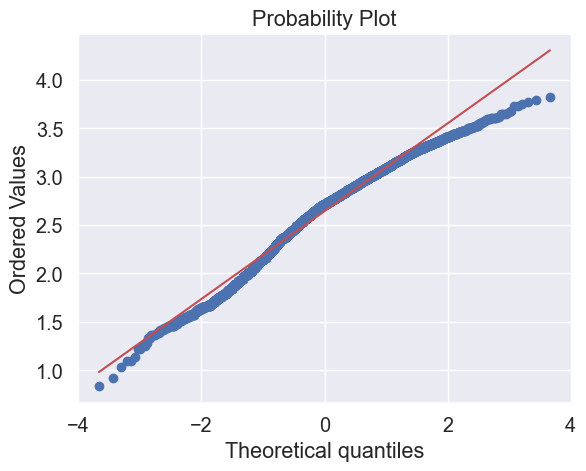

Skewness & TempRise: -0.498182
Kurtosis & TempRise: -0.146264


In [88]:
log_temp_rise = np.log1p(TemperatureRise)

sns.distplot(log_temp_rise , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_temp_rise)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('log_TemperatureRise')
plt.title('log_TemperatureRise distribution')

## TemperatureRise mean and median value display
plt.axvline(log_temp_rise.mean(), color='black')
plt.axvline(log_temp_rise.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_temp_rise, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & TempRise: %f" % log_temp_rise.skew())
print("Kurtosis & TempRise: %f" % log_temp_rise.kurt())

#### log transform 변환하여 확인하기(temperatureC)

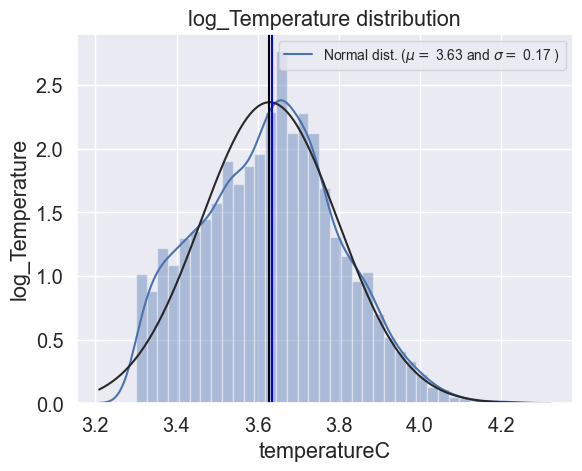

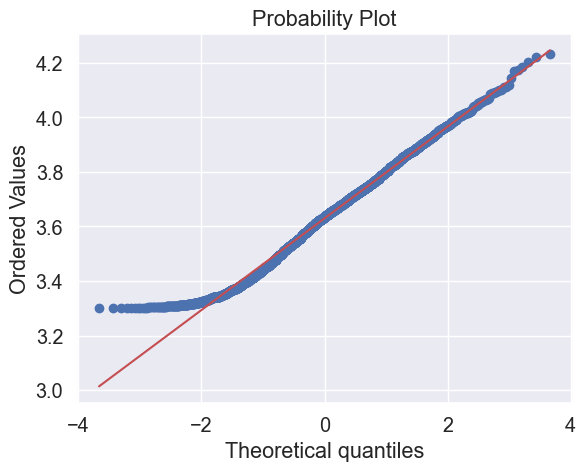

Skewness & Temp: 0.135794
Kurtosis & Temp: -0.438527


In [89]:
log_temp = np.log1p(Temperature)

sns.distplot(log_temp , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_temp)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('log_Temperature')
plt.title('log_Temperature distribution')

## TemperatureRise mean and median value display
plt.axvline(log_temp.mean(), color='black')
plt.axvline(log_temp.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_temp, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % log_temp.skew())
print("Kurtosis & Temp: %f" % log_temp.kurt())

#### Relationship with numerical variables

##### Targer vs. pulseRepetRate

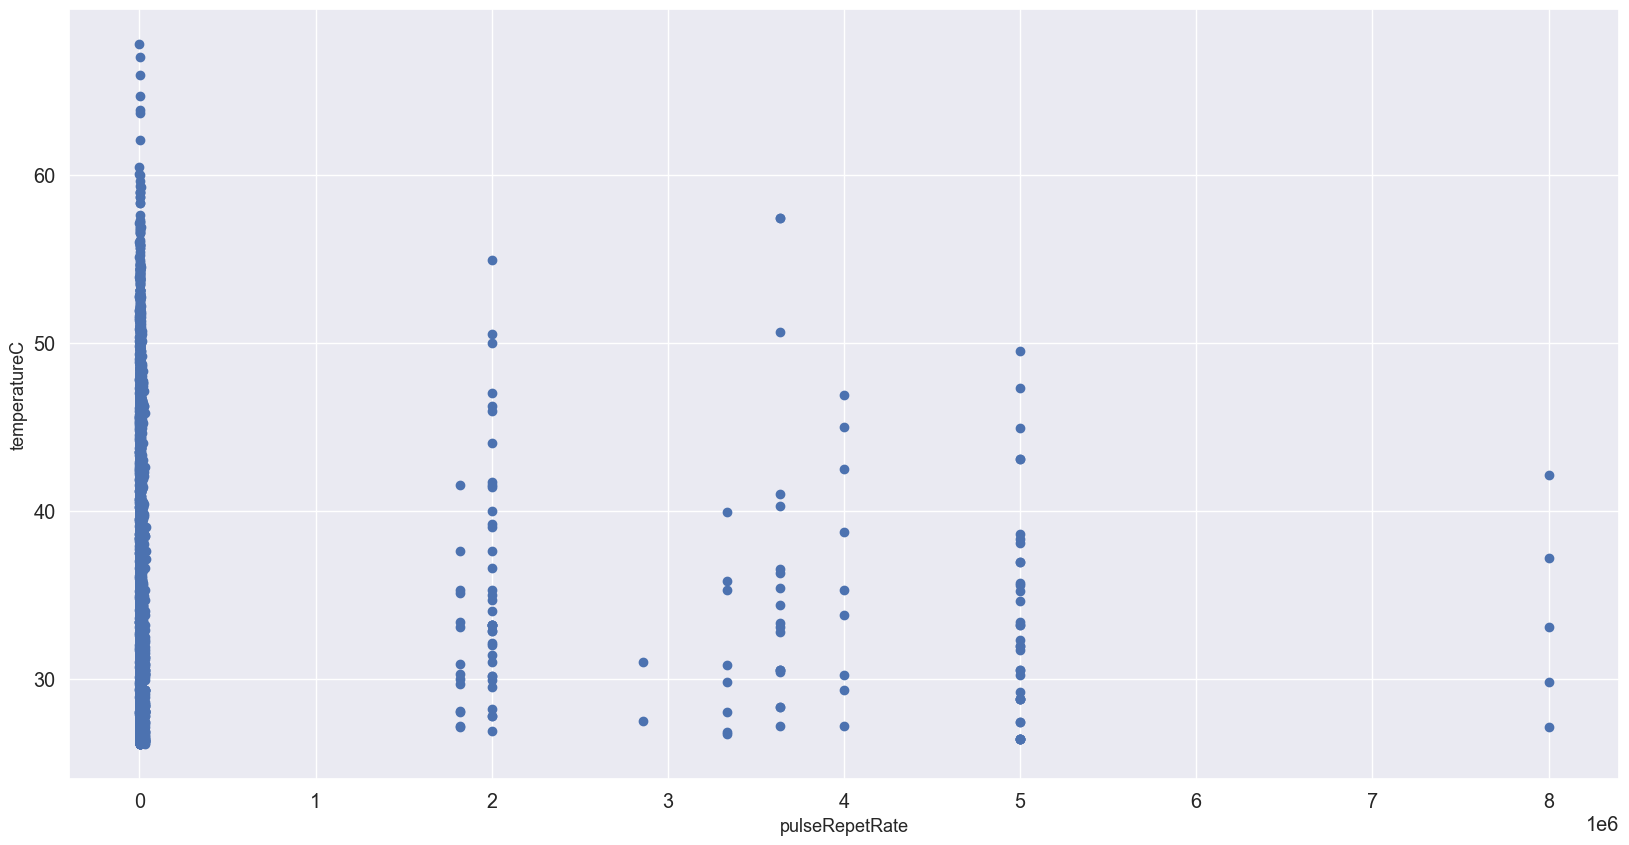

In [90]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseRepetRate'], y = AOP_data['temperatureC'])
plt.xlabel('pulseRepetRate', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

In [91]:
print(AOP_data['pulseRepetRate'].unique())
print(AOP_data['pulseRepetRate'].value_counts())
print('pulseRepetRate 종류 갯수:', AOP_data['pulseRepetRate'].nunique())
print('-----')

over_1MHz = AOP_data[AOP_data['pulseRepetRate']>1000000]
print(over_1MHz['pulseRepetRate'].value_counts())

[2687.         1810.52001953 1219.94995117 ... 2770.43994141 1505.69995117
 3434.07006836]
pulseRepetRate
3.000000e+04    67
2.000000e+06    38
5.000000e+06    36
4.000000e+03    30
3.633720e+03    27
                ..
1.414030e+03     1
1.885370e+03     1
2.828050e+03     1
8.668500e+02     1
3.434070e+03     1
Name: count, Length: 3624, dtype: int64
pulseRepetRate 종류 갯수: 3624
-----
pulseRepetRate
2000000.0    38
5000000.0    36
3636400.0    19
1818200.0    14
4000000.0     9
3333300.0     8
8000000.0     5
2857100.0     2
Name: count, dtype: int64


##### CW관련 데이터 삭제(pulseRepetRate > 1000000)

In [92]:
# pulseRepetRate 1000000 이상일 경우, 행 삭제
AOP_data = AOP_data[AOP_data['pulseRepetRate'] < 1000000]

over_1MHz = AOP_data[AOP_data['pulseRepetRate']>1000000]
print(over_1MHz['pulseRepetRate'].value_counts())

Series([], Name: count, dtype: int64)


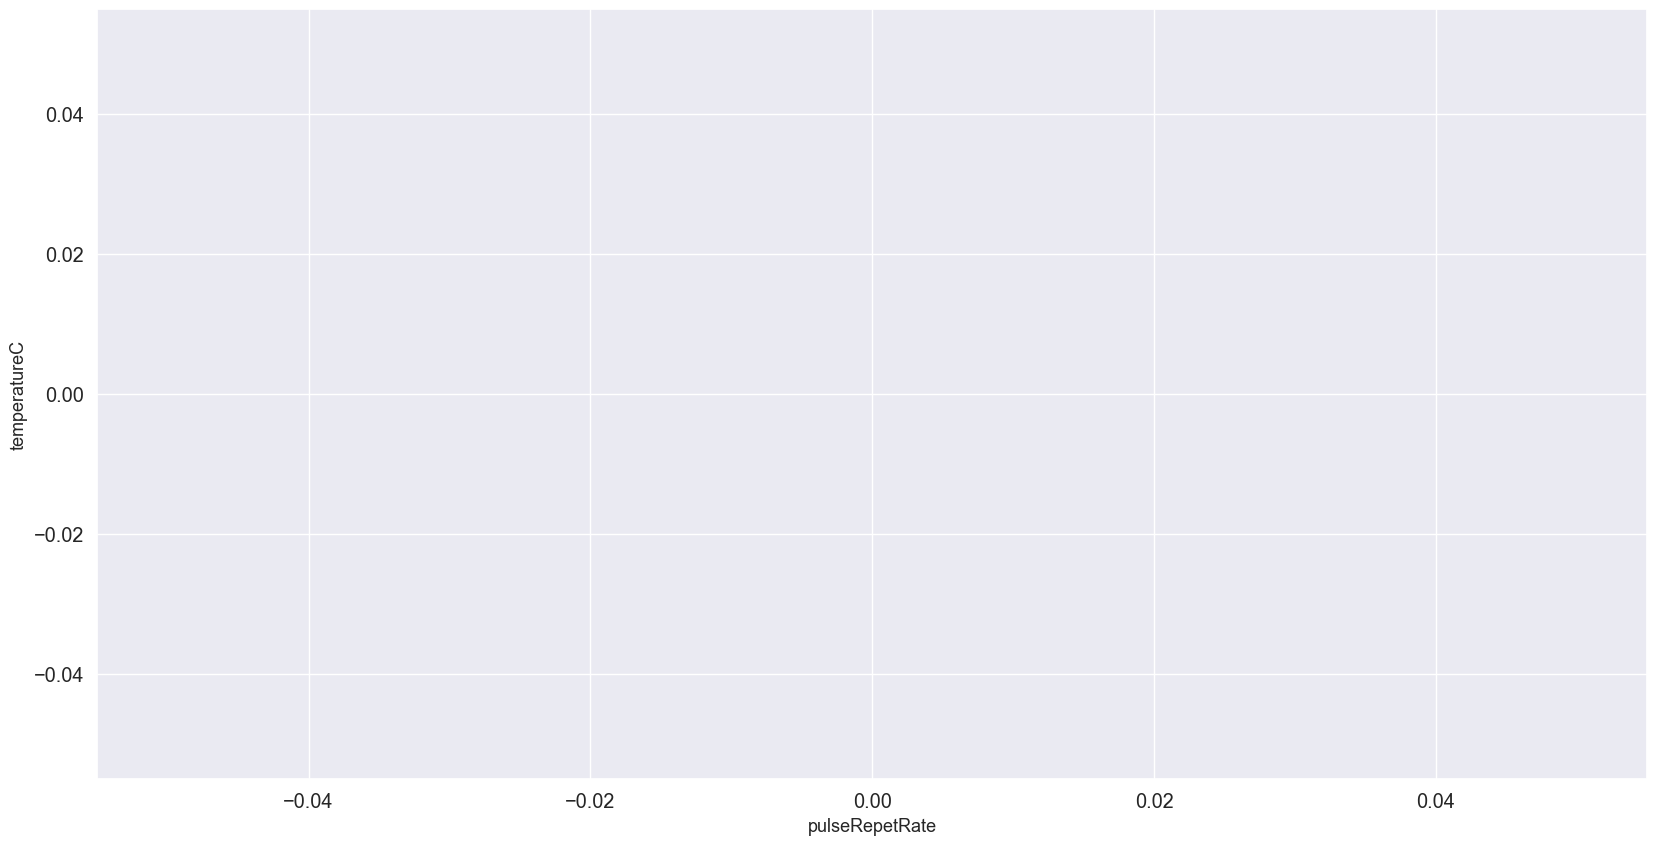

In [93]:
below_100Hz = AOP_data[AOP_data['pulseRepetRate']<100]

fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = below_100Hz['pulseRepetRate'], y = below_100Hz['temperatureC'])
plt.xlabel('pulseRepetRate', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. NumTxCycles

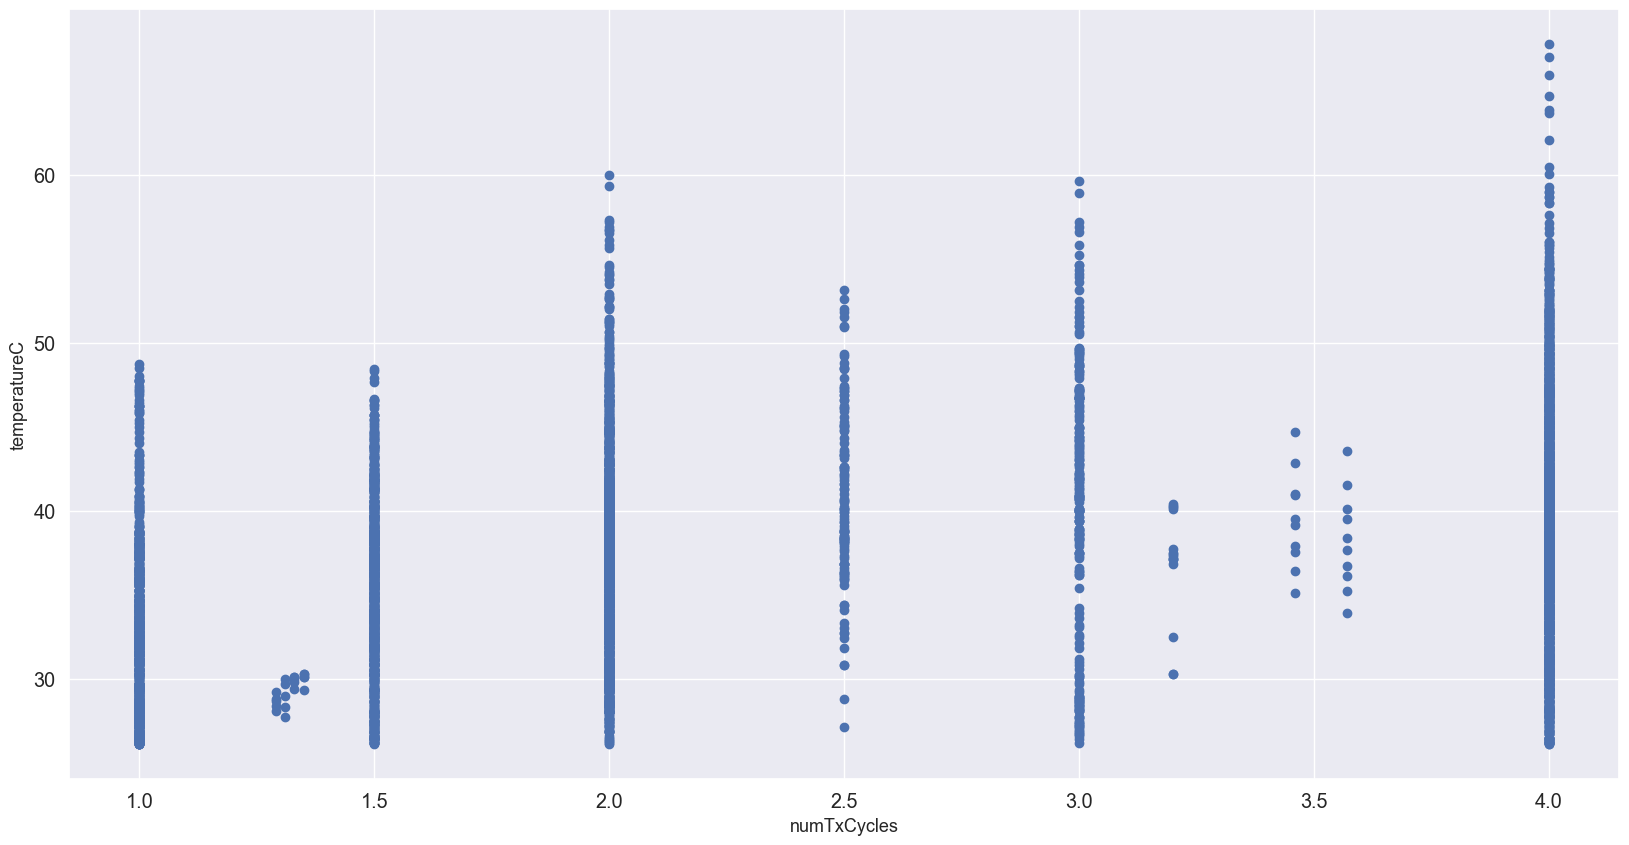

In [94]:
fig, axs = plt.subplots(figsize=(20,10))
axs.scatter(x = AOP_data['numTxCycles'], y = AOP_data['temperatureC'])
plt.xlabel('numTxCycles', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. txFrequencyHz

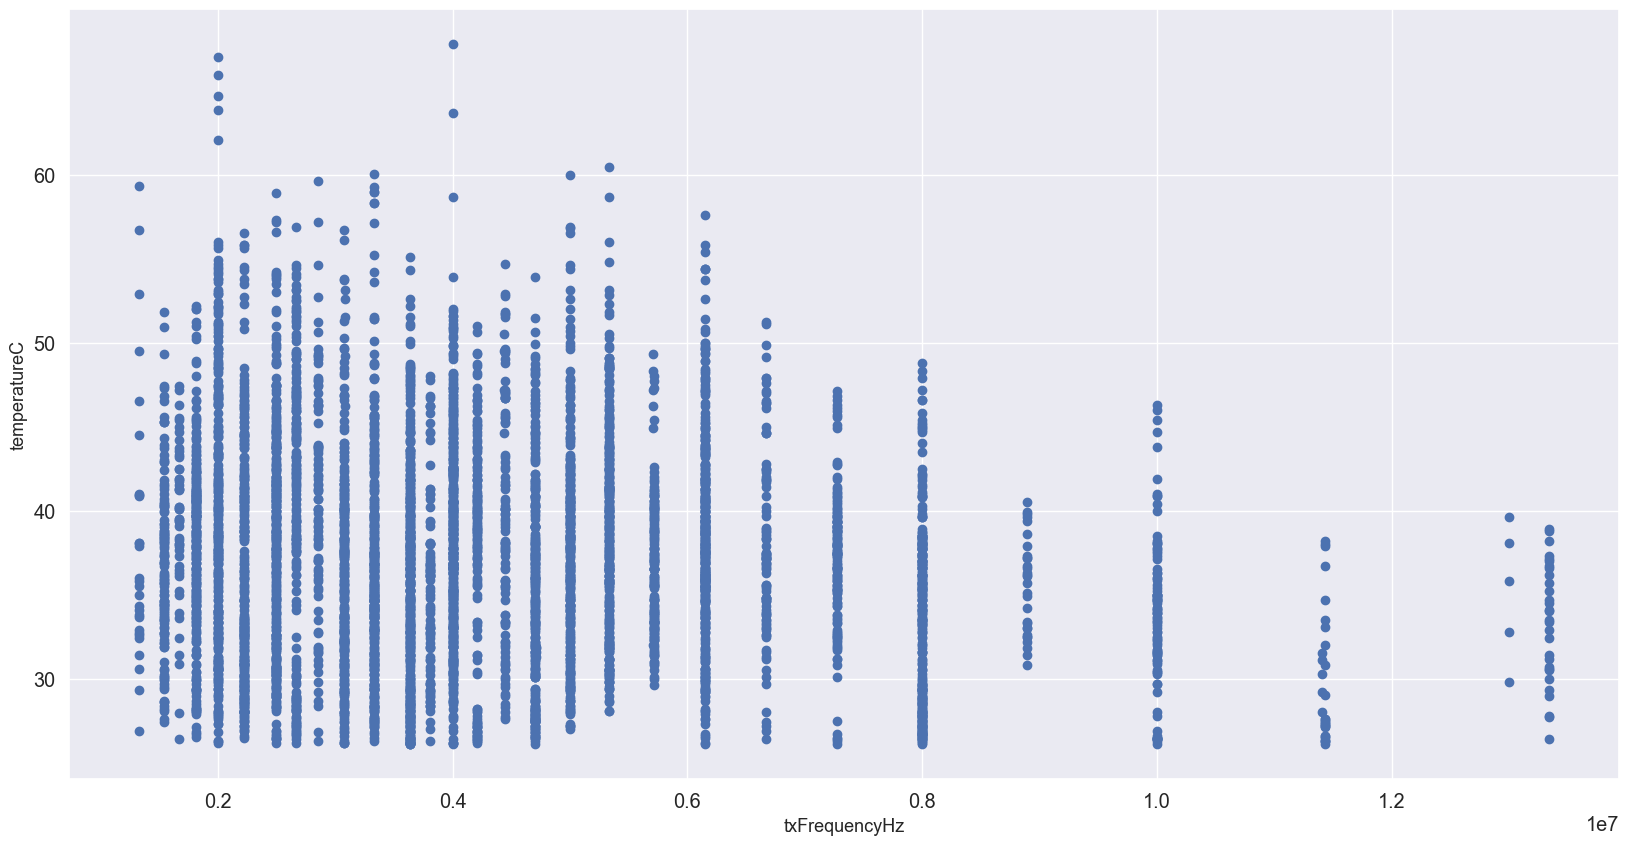

In [95]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['txFrequencyHz'], y = AOP_data['temperatureC'])
plt.xlabel('txFrequencyHz', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. voltage

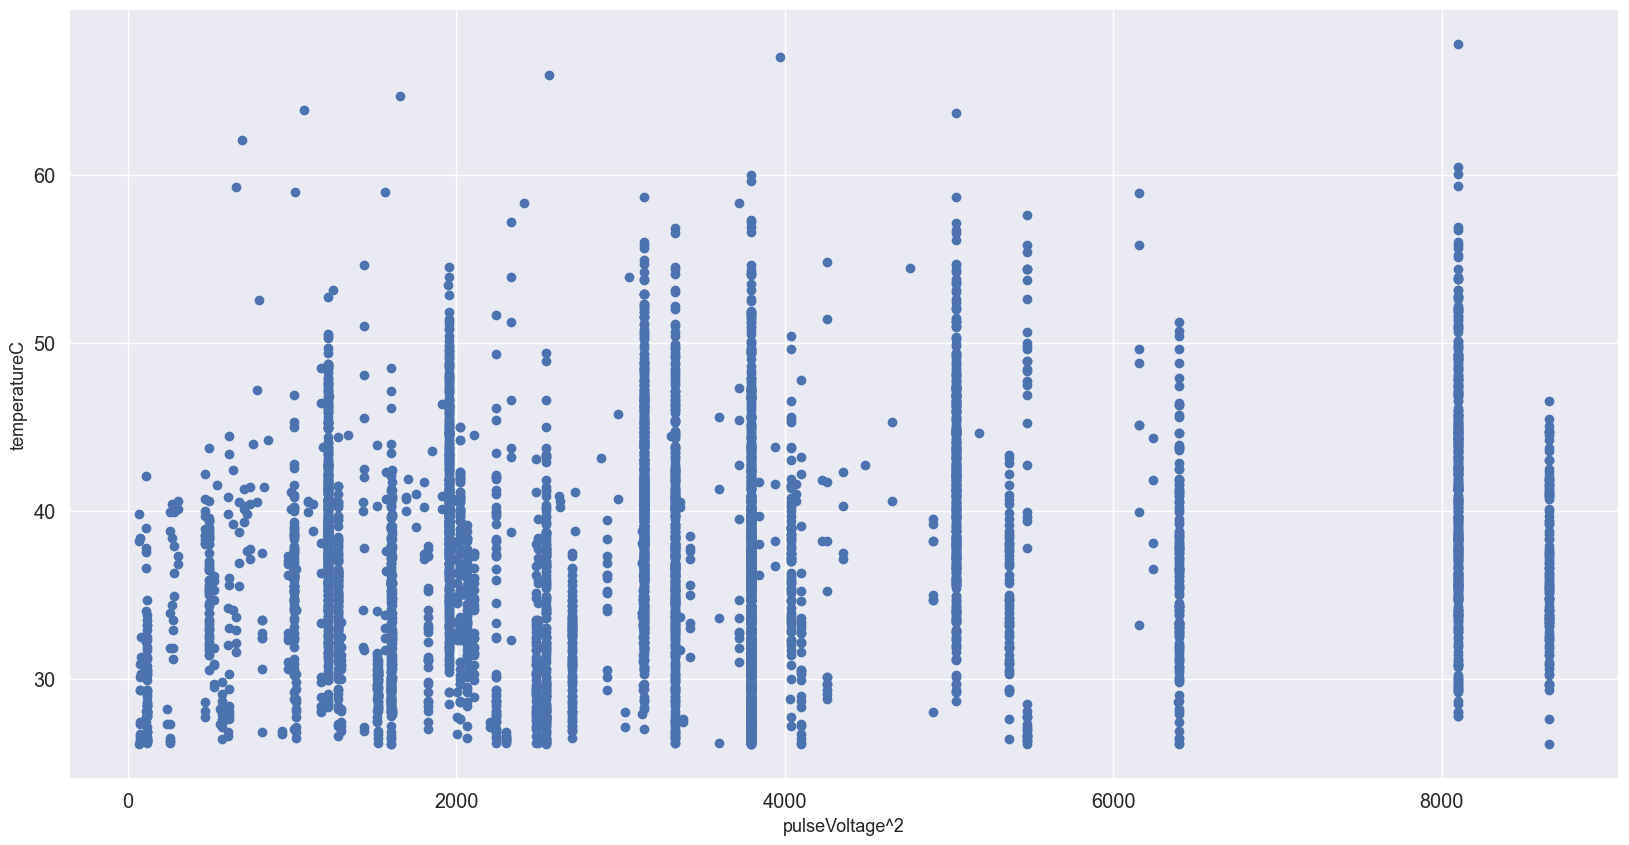

In [96]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'], y = AOP_data['temperatureC'])
plt.xlabel('pulseVoltage^2', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. Energy

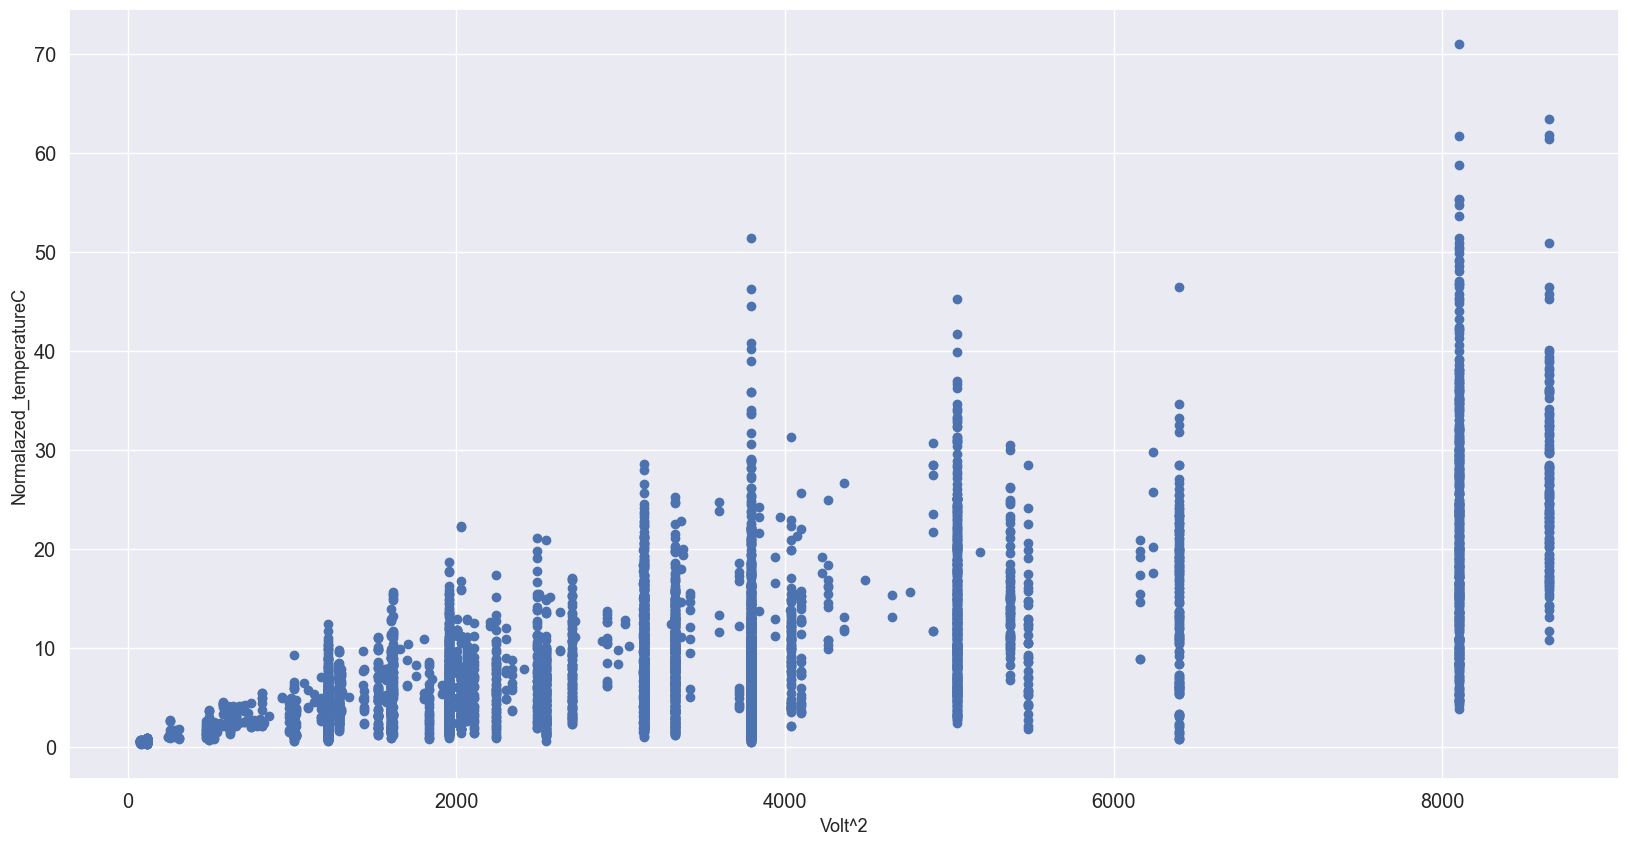

In [97]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'], 
            y = (AOP_data['temperatureC']) / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)))
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

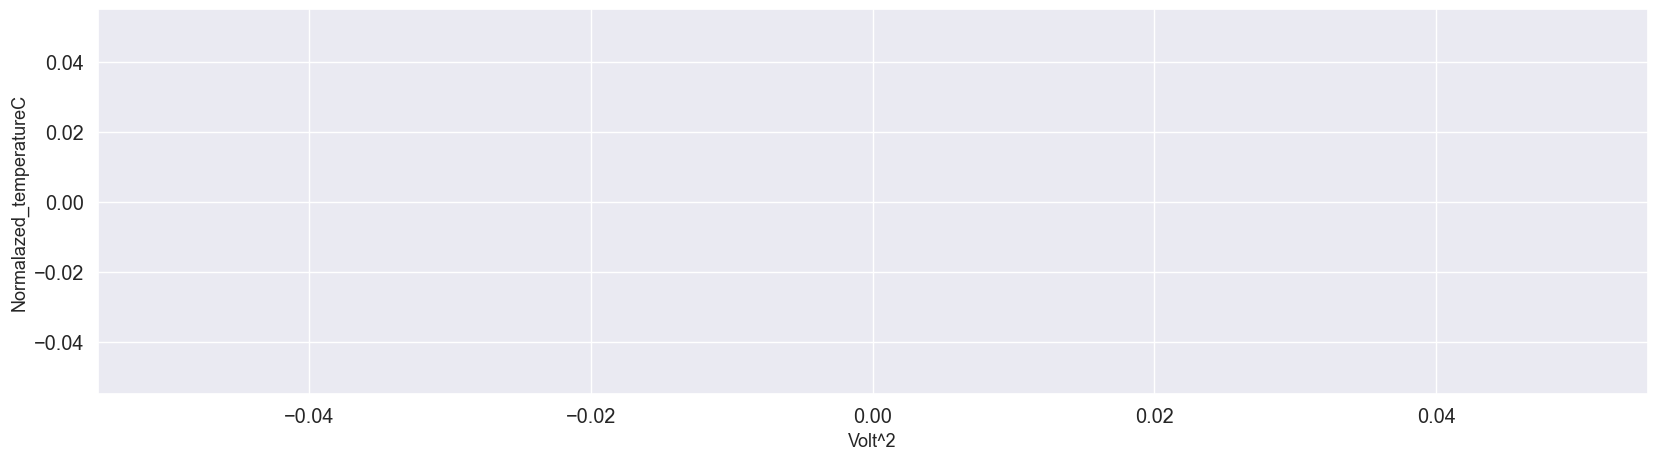

In [98]:
AOP_data['volt2'] = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage']
AOP_data['normal_Temp'] = AOP_data['temperatureC'] / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000))


outlier = AOP_data[(AOP_data['volt2'] < 3500) & (AOP_data['normal_Temp'] > 30)]


fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x = outlier['volt2'], y = outlier['normal_Temp'])
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

In [99]:
print(outlier.shape)
outlier.head(10)

(0, 24)


,Database,temperatureId,probeId,tempSSId,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,numTxElements,...,pulseRepetRate,scanRange,probePitchCm,probeRadiusCm,probeElevAperCm0,probeNumElements,probeElevFocusRangCm,probeDescription,volt2,normal_Temp


##### TemperatureRise 기준으로 3도 이상 올라가지 않은 데이터 확인

(18, 24)


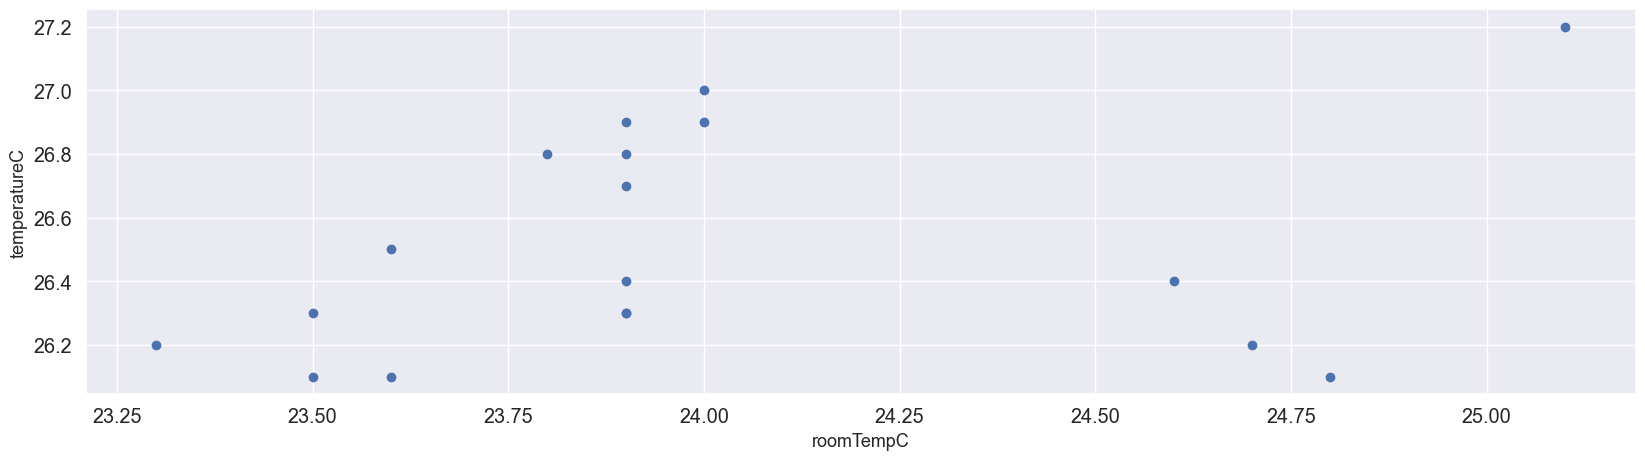

In [100]:
below_3deg = AOP_data[(AOP_data['temperatureC']) - (AOP_data['roomTempC']) <= 3]
print(below_3deg.shape)

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=below_3deg['roomTempC'], y=below_3deg['temperatureC'])
plt.xlabel('roomTempC', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### roomTempC가 26도를 넘는 case 확인

(0, 24)


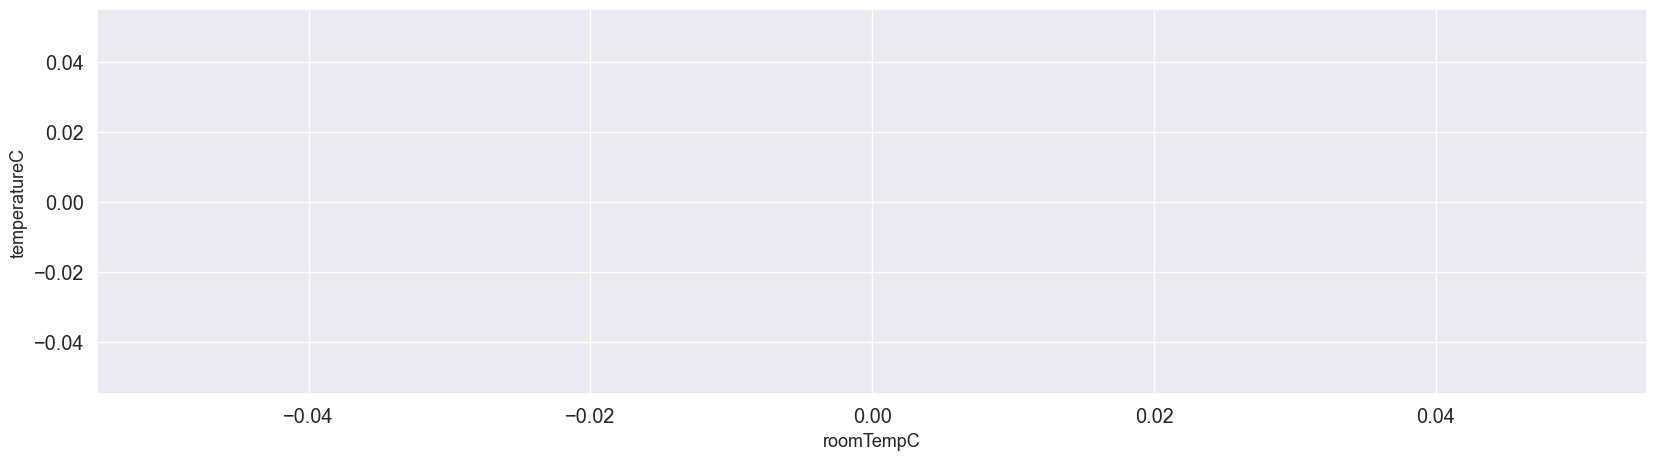

In [101]:
over_roomT = AOP_data[AOP_data['roomTempC'] > 26]
print(over_roomT.shape)

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=over_roomT['roomTempC'], y=over_roomT['temperatureC'])
plt.xlabel('roomTempC', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

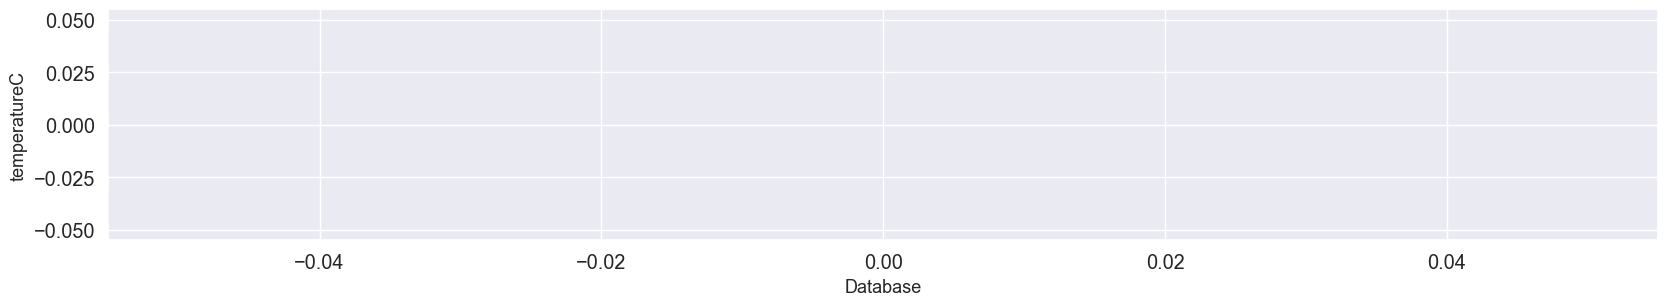

In [102]:
fig, axs = plt.subplots(figsize=(20, 3))
axs.scatter(x=over_roomT['Database'], y=over_roomT['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Drop unnecessary data
- ambient 온도가 26도 이상일 경우, Drop.
- temperatureRise가 2도 이하일 경우, Drop

In [103]:
print('Before drop unnecessary data:', AOP_data.shape)

## <Drop unnecessary data>
## pulseRepetRate가 18000(CW) 이상이거나 또는 온도가 26도 미만일 경우는 Drop.
# - As below, Drop condition output test code.
#     - AOP_data[(AOP_data['roomTempC']>26)].to_csv('drop_data.csv')
AOP_data = AOP_data.drop(AOP_data[(AOP_data['roomTempC']>26) | ((AOP_data['temperatureC']) - (AOP_data['roomTempC']) <= 2)].index)
print('After drop unnecessary data:', AOP_data.shape)

Before drop unnecessary data: (5430, 24)
After drop unnecessary data: (5421, 24)


##### target data check

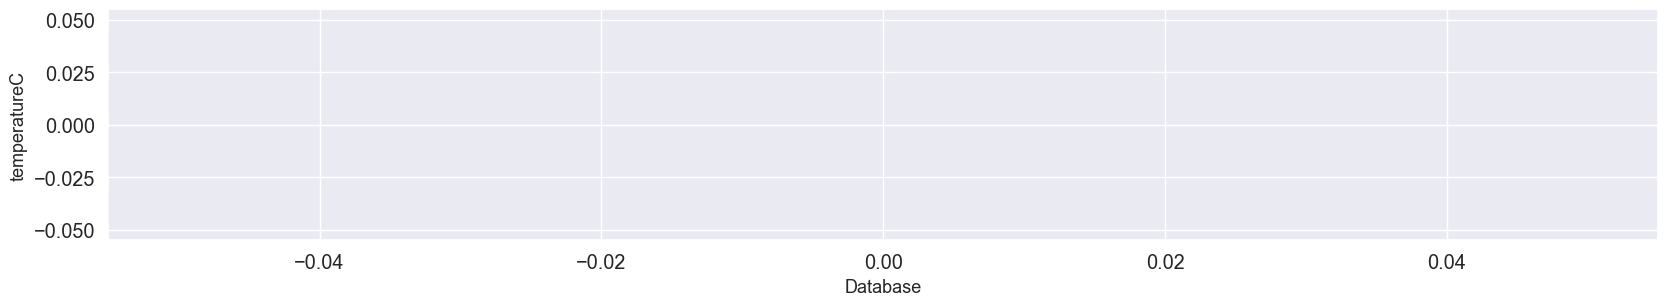

In [104]:
over_roomT = AOP_data[AOP_data['roomTempC'] > 26]

fig, axs = plt.subplots(figsize=(20, 3))
axs.scatter(x=over_roomT['Database'], y=over_roomT['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

(0, 24)


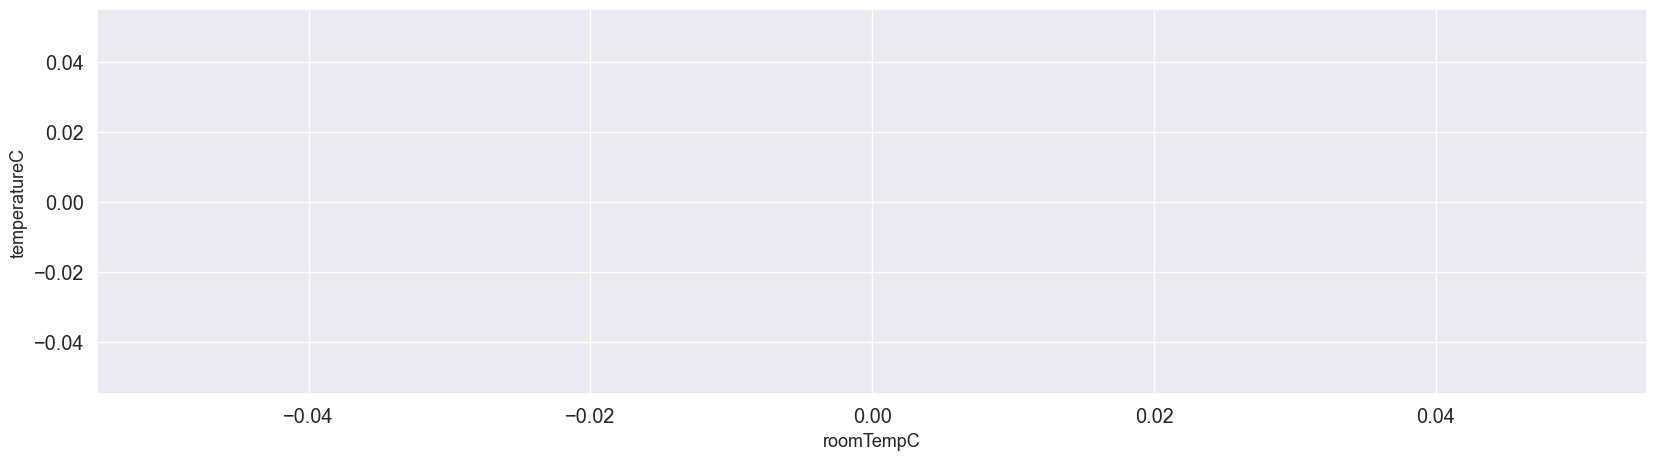

In [105]:
below_2deg = AOP_data[(AOP_data['temperatureC']) - (AOP_data['roomTempC']) <= 2]
print(below_2deg.shape)

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=below_2deg['roomTempC'], y=below_2deg['temperatureC'])
plt.xlabel('roomTempC', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### another outlier check

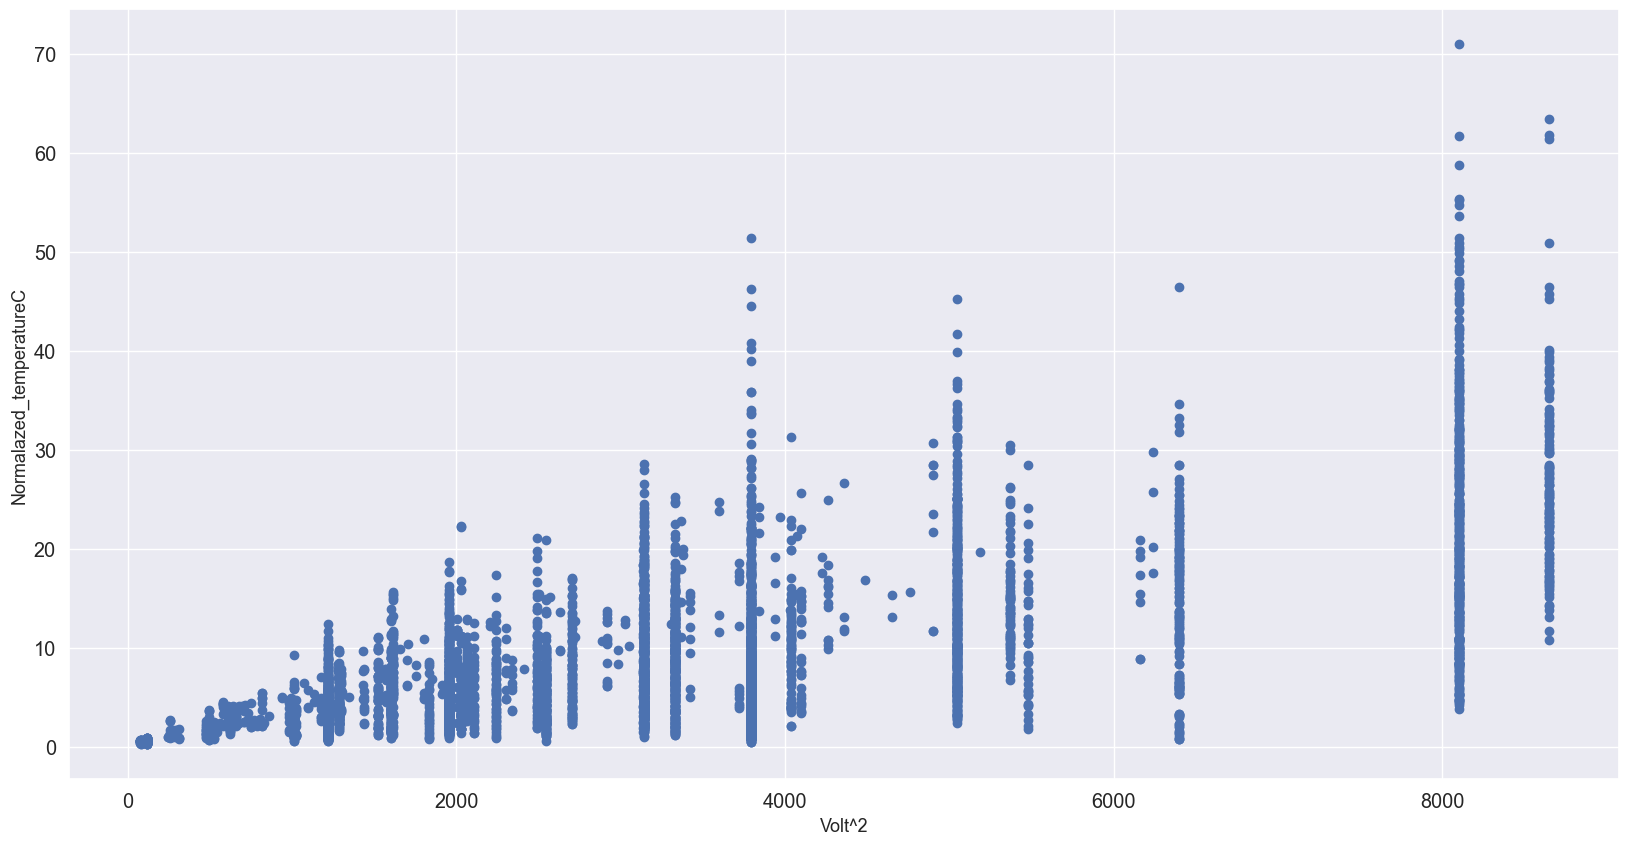

In [106]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['volt2'], 
            y = AOP_data['normal_Temp'])
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

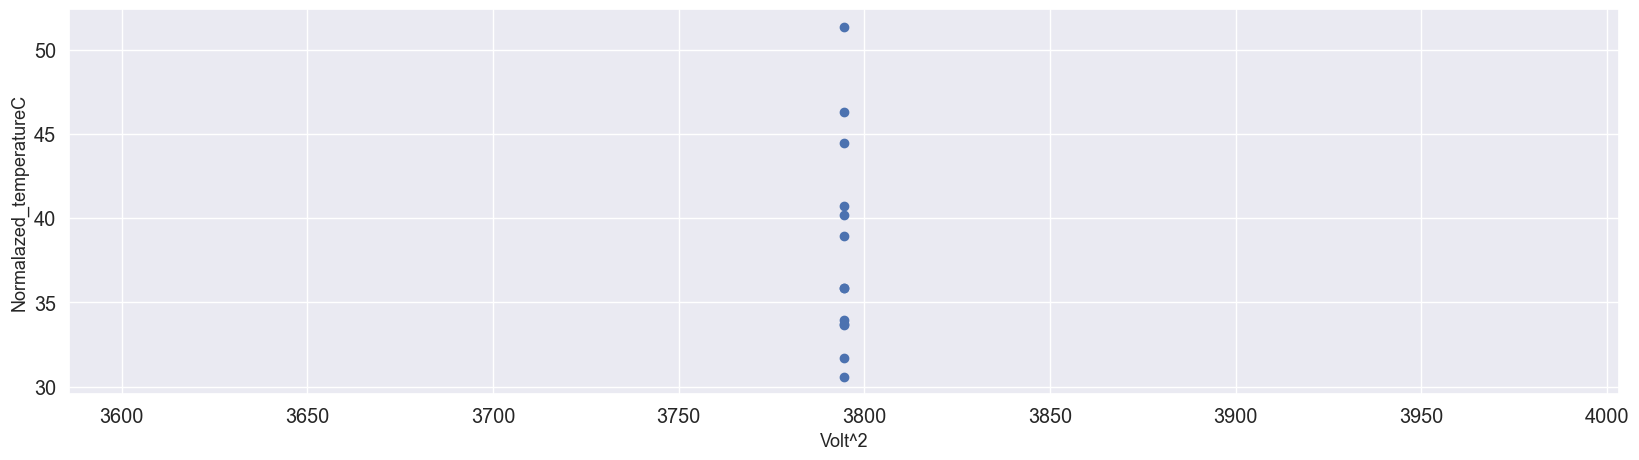

In [107]:
outlier2 = AOP_data[(AOP_data['volt2'] < 4000) & (AOP_data['normal_Temp'] > 30)]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x = outlier2['volt2'], y = outlier2['normal_Temp'])
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

In [108]:
outlier2.head(15)

,Database,temperatureId,probeId,tempSSId,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,numTxElements,...,pulseRepetRate,scanRange,probePitchCm,probeRadiusCm,probeElevAperCm0,probeNumElements,probeElevFocusRangCm,probeDescription,volt2,normal_Temp
81,Griffin_r01,692,11284923,784,3,23.900000,61.599998,33.599998,1.5,64,...,664.190002,0.132179,0.0212,1.48,0.5,128.0,1.9,Convex,3794.559812,33.725288
87,Griffin_r01,700,11284923,784,3,23.900000,61.599998,33.400002,1.5,96,...,546.570007,0.132179,0.0212,1.48,0.5,128.0,1.9,Convex,3794.559812,40.738912
89,Griffin_r01,703,11284923,784,3,23.900000,61.599998,34.900002,1.5,96,...,649.349976,0.731390,0.0212,1.48,0.5,128.0,1.9,Convex,3794.559812,35.830705
93,Griffin_r01,709,11284923,784,3,23.799999,61.599998,32.000000,1.5,128,...,415.420013,0.132179,0.0212,1.48,0.5,128.0,1.9,Convex,3794.559812,51.353648
95,Griffin_r01,712,11284923,784,3,23.799999,61.599998,32.700001,1.5,128,...,470.989990,0.731390,0.0212,1.48,0.5,128.0,1.9,Convex,3794.559812,46.285486
97,Griffin_r01,714,11284923,784,3,23.799999,61.599998,34.400002,1.5,128,...,588.510010,1.471590,0.0212,1.48,0.5,128.0,1.9,Convex,3794.559812,38.968469
98,Griffin_r01,716,11284923,784,3,23.799999,61.599998,36.000000,1.5,128,...,706.210022,2.070800,0.0212,1.48,0.5,128.0,1.9,Convex,3794.559812,33.984225
1383,Griffin_r01,5279,11370949,5147,3,21.500000,61.599998,29.400000,2.0,48,...,437.059998,0.000739,0.0148,0.00,0.6,64.0,5.5,Phase,3794.559812,33.633826
1384,Griffin_r01,5280,11370949,5147,3,21.299999,61.599998,30.299999,2.0,48,...,495.250000,0.000895,0.0148,0.00,0.6,64.0,5.5,Phase,3794.559812,30.590610
1388,Griffin_r01,5284,11370949,5147,3,21.400000,61.599998,28.000000,2.0,64,...,314.700012,0.000739,0.0148,0.00,0.6,64.0,5.5,Phase,3794.559812,44.486811


##### scanRange에 의한 차이로 보임

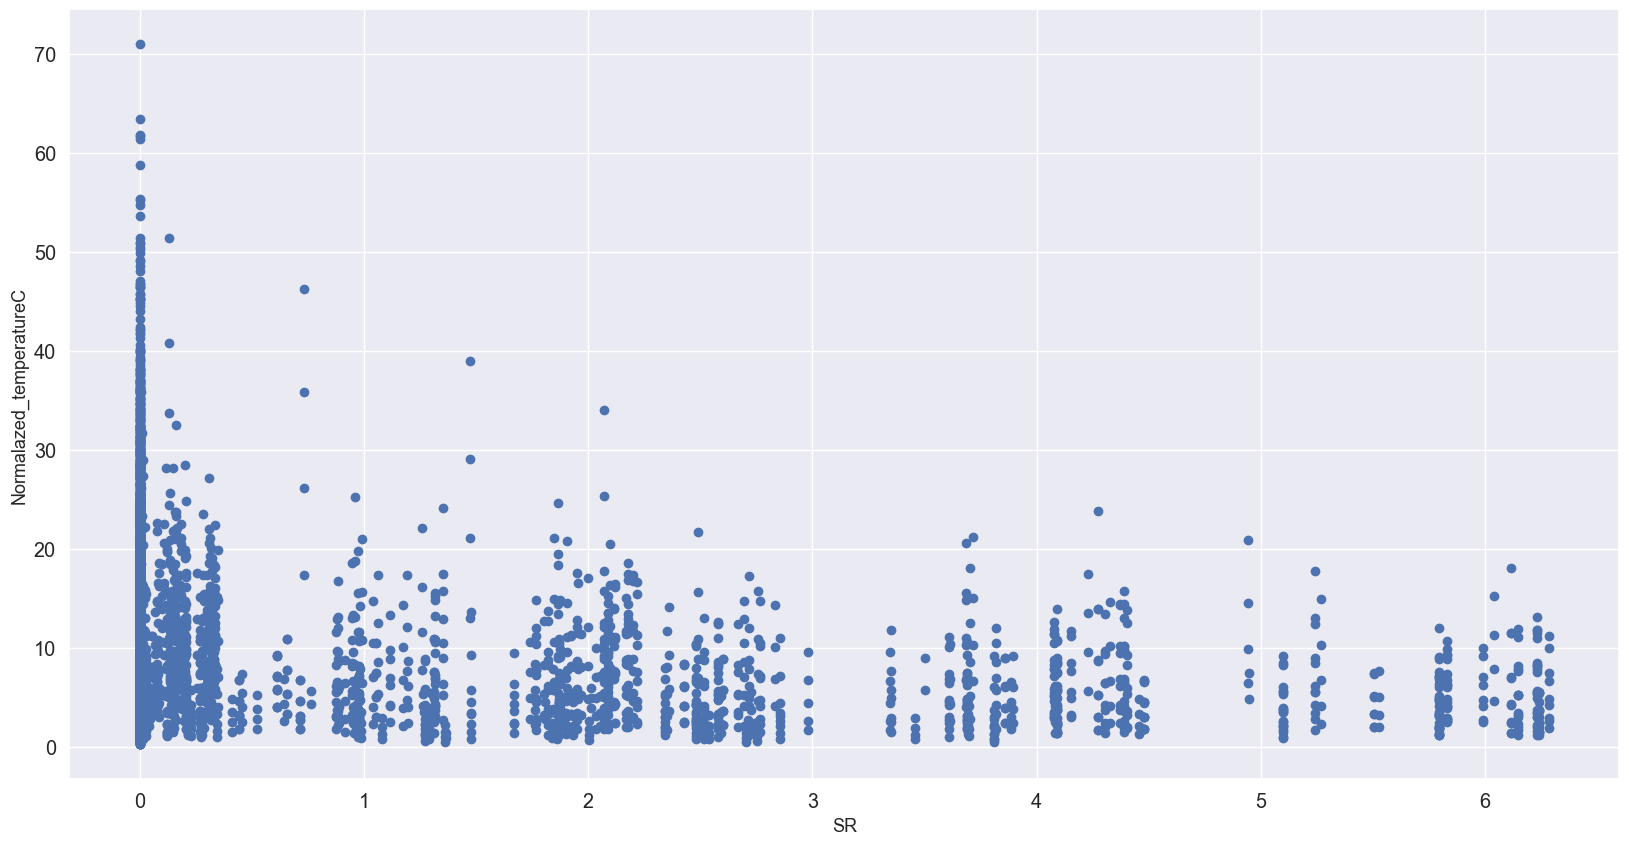

In [109]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['scanRange'], y = (AOP_data['temperatureC']) / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)))
plt.xlabel('SR', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

---
>### Relationship with categorical features

(-0.5, 12.5, 0.0, 0.01)

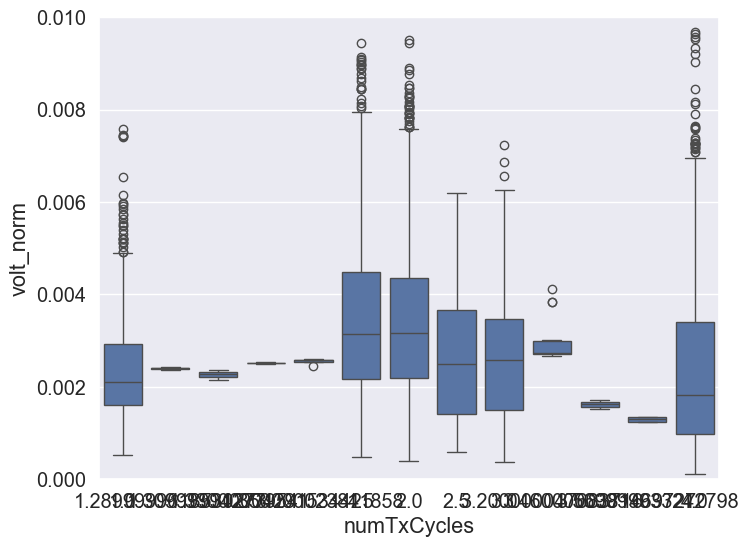

In [110]:
## box plot normal_temp vs. cycle
var = 'numTxCycles'
target = 'normal_Temp'

AOP_data['volt_norm'] = AOP_data['normal_Temp'] / (AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'])
volt_norm = 'volt_norm'

data = pd.concat([AOP_data[var], AOP_data[volt_norm]], axis=1)

fig, axs = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=volt_norm, data=data)
fig.axis(ymin=0, ymax=0.01)

---
>### 쓸모없는 데이터 삭제 후, 확률 및 분포 확인하기
- temperatureC 선택하여 데이터 분석하기

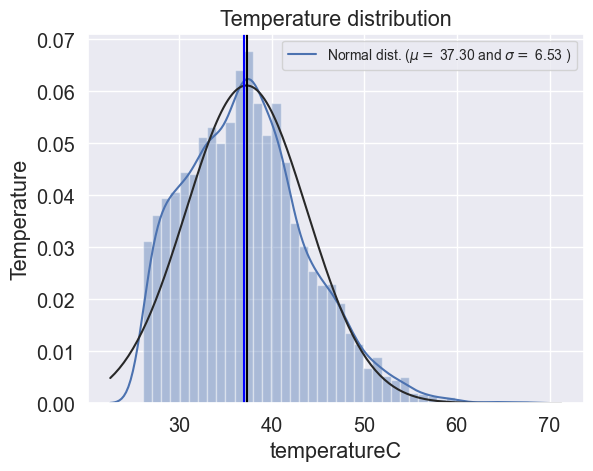

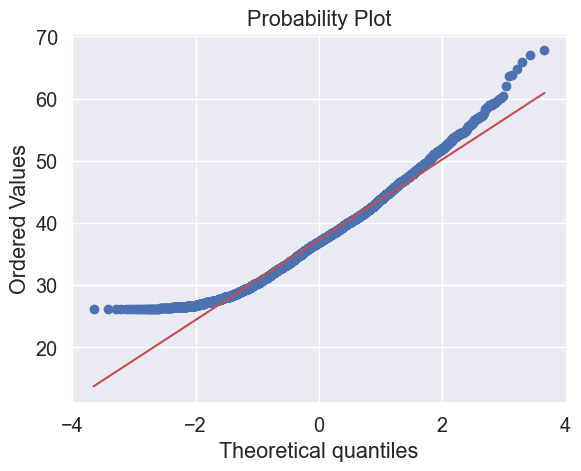

Skewness & Temp: 0.546705
Kurtosis & Temp: 0.222851


In [111]:
Temperature = (AOP_data['temperatureC'])

sns.distplot(Temperature , fit=norm);

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Temperature)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Temperature')
plt.title('Temperature distribution')

## Temperature mean and median value display
plt.axvline(Temperature.mean(), color='black')
plt.axvline(Temperature.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Temperature, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % Temperature.skew())
print("Kurtosis & Temp: %f" % Temperature.kurt())

In [112]:
print(AOP_data.columns)
print(AOP_data.shape)

Index(['Database', 'temperatureId', 'probeId', 'tempSSId', 'measSetNum',
       'roomTempC', 'pulseVoltage', 'temperatureC', 'numTxCycles',
       'numTxElements', 'txFrequencyHz', 'elevAperIndex',
       'isTxAperModulationEn', 'txpgWaveformStyle', 'pulseRepetRate',
       'scanRange', 'probePitchCm', 'probeRadiusCm', 'probeElevAperCm0',
       'probeNumElements', 'probeElevFocusRangCm', 'probeDescription', 'volt2',
       'normal_Temp', 'volt_norm'],
      dtype='object')
(5421, 25)


---
>### one hot encoder: probeDescription

In [113]:
# one-hot 인코딩 수행
encoded = pd.get_dummies(AOP_data['probeDescription'])

# 인코딩 결과는 원본 데이터프레임에 다시 합쳐줍니다.
AOP_data = pd.concat([AOP_data, encoded], axis=1)

# 원본 범주형 데이터 열은 더 이상 필요 없으므로 삭제합니다.
AOP_data.drop('probeDescription', axis=1, inplace=True)

In [114]:
AOP_data.head()

,Database,temperatureId,probeId,tempSSId,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,numTxElements,...,probeRadiusCm,probeElevAperCm0,probeNumElements,probeElevFocusRangCm,volt2,normal_Temp,volt_norm,Convex,Linear,Phase
0,Griffin_r01,325,11268278,147,4,22.299999,34.899807,34.000000,2.0,128,...,6.23,1.4,128.0,4.88,1217.996527,6.326758,0.005194,True,False,False
1,Griffin_r01,327,11268278,147,4,22.400000,44.226025,35.099998,2.0,128,...,6.23,1.4,128.0,4.88,1955.941254,9.693347,0.004956,True,False,False
2,Griffin_r01,329,11268278,147,4,22.799999,56.044472,36.299999,2.0,128,...,6.23,1.4,128.0,4.88,3140.982813,14.877659,0.004737,True,False,False
3,Griffin_r01,332,11268278,147,4,23.000000,71.021141,37.599998,2.0,128,...,6.23,1.4,128.0,4.88,5044.002476,22.870767,0.004534,True,False,False
4,Griffin_r01,334,11268278,147,4,23.100000,90.000000,38.799999,2.0,128,...,6.23,1.4,128.0,4.88,8100.000000,35.025636,0.004324,True,False,False


---
>### Data Correlation
- Correlation map to see how features are correlated with TemperatureRise

<Axes: title={'center': 'Temperature Correlation of Features'}>

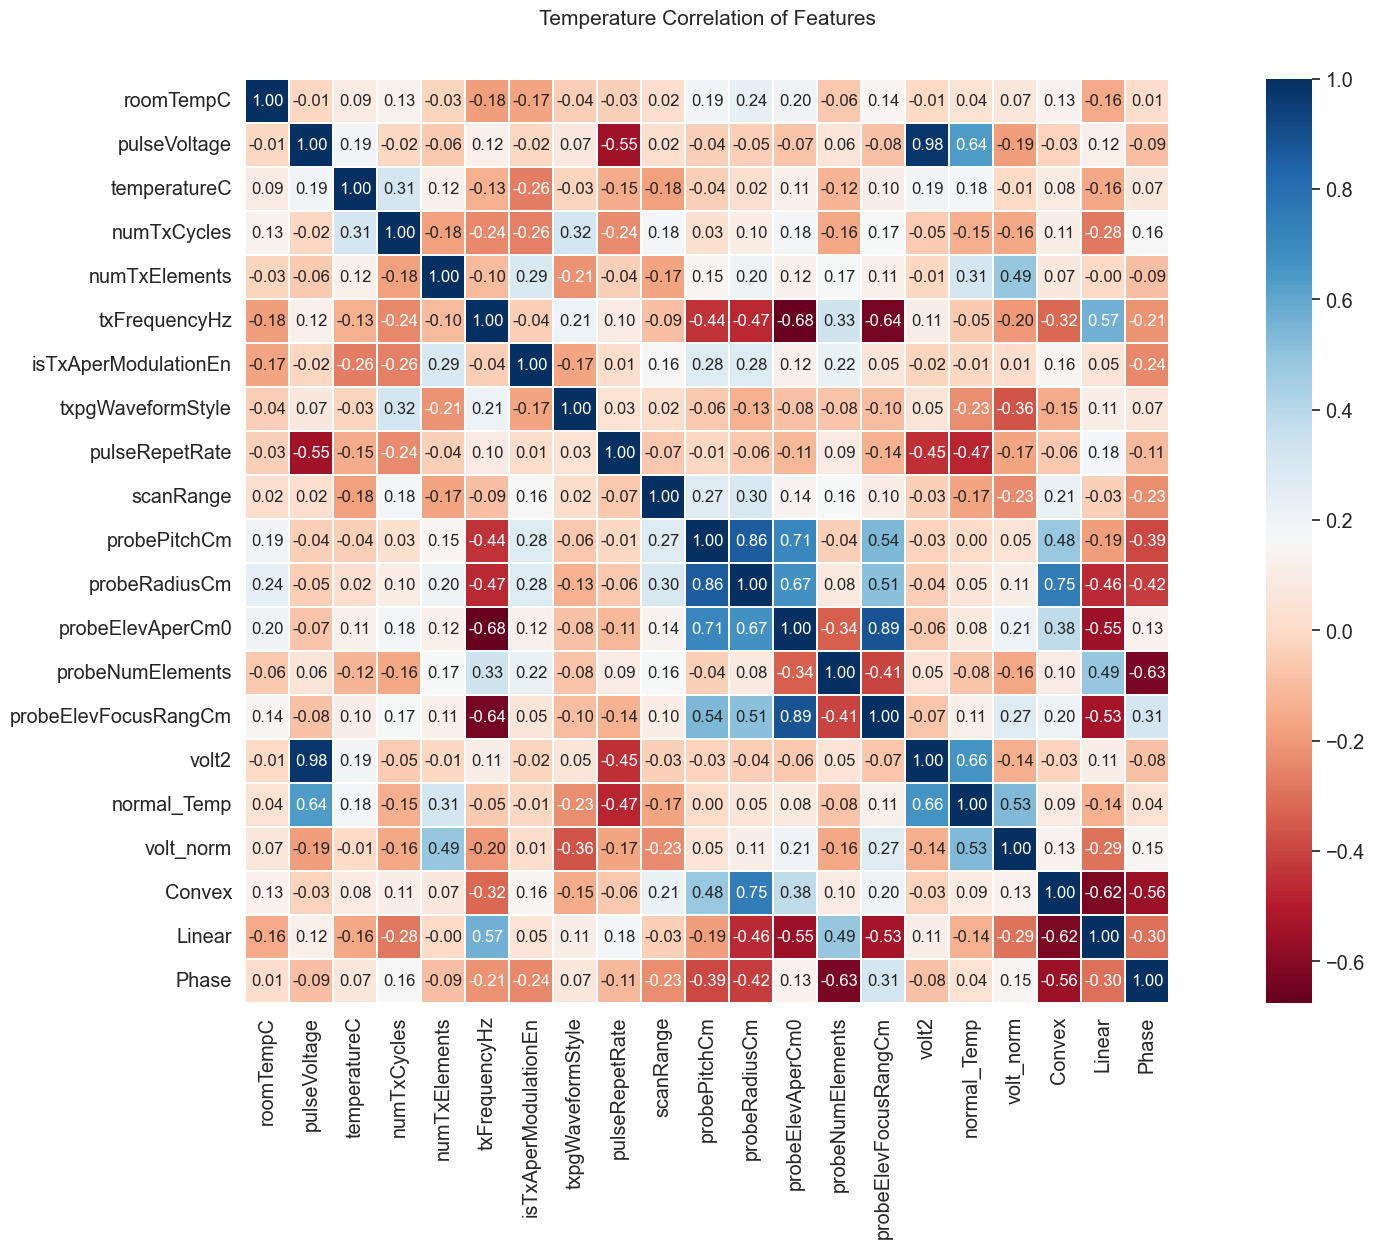

In [115]:
heatmap_data = AOP_data[['roomTempC', 'pulseVoltage', 'temperatureC', 'numTxCycles',
       'numTxElements', 'txFrequencyHz', 'isTxAperModulationEn', 'txpgWaveformStyle', 'pulseRepetRate',
       'scanRange', 'probePitchCm', 'probeRadiusCm', 'probeElevAperCm0',
       'probeNumElements', 'probeElevFocusRangCm', 'volt2',
       'normal_Temp', 'volt_norm', 'Convex','Linear','Phase']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(25, 12))
plt.title('Temperature Correlation of Features', y=1.05, size=15)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, fmt='.2f',
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 12})

---
>### 데이터선택 및 데이터 구분하기
- 데이터 선택(=feature list)

In [132]:
## 데이터 구분
feature_list = ['probeId', 'roomTempC', 'pulseVoltage', 'numTxCycles', 'numTxElements', 
                'txFrequencyHz', 'elevAperIndex', 'isTxAperModulationEn', 'txpgWaveformStyle', 'pulseRepetRate',
                'scanRange', 'probePitchCm', 'probeRadiusCm', 'probeElevAperCm0', 'probeNumElements', 
                'probeElevFocusRangCm', 'volt2', 'normal_Temp', 'volt_norm', 'Convex',
                'Linear','Phase']

data = AOP_data[feature_list].to_numpy()
target = AOP_data['temperatureC'].to_numpy()

- data / target 데이터 --> train / test 구분하기

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error


train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True)

>### 머신러닝 모델 사용하기
#### 1) Linear-Regression 모델 사용하기

In [119]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)


## PolynomialFeatures 데이터를 train_input / test_input에 넣어서 아래 common에 입력
train_input = train_scaled
test_input = test_scaled


from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()


scores = cross_validate(model_lr, train_input, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_lr.fit(train_input, train_target)
test_prediction = model_lr.predict(test_input)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(test_target, test_prediction)
print(f'|(타깃 - 예측값)|: {mae:.3f}')


{'fit_time': array([0.00798869, 0.00800252, 0.00699115, 0.0079968 , 0.00899935]), 'score_time': array([0.00100017, 0.0009973 , 0.00100327, 0.0010047 , 0.0010047 ]), 'test_score': array([-5.04852678, -5.54589228, -5.11317488, -5.30125109, -5.39109094]), 'train_score': array([-5.32037153, -5.18993364, -5.30008604, -5.25314815, -5.23173339])}
Train RMSE: 5.259
train_val RMSE: 5.280
Test RMSE: 26.421
|(타깃 - 예측값)|: 4.046


#### 2) RandomForest-Regressor 모델 사용하기

In [120]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


model_random = RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_split=2, n_estimators=90, n_jobs=-1)


scores = cross_validate(model_random, train_input, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_random.fit(train_input, train_target)
test_prediction = model_random.predict(test_input)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(test_target, test_prediction)
print(f'|(타깃 - 예측값)|: {mae:.3f}')


{'fit_time': array([1.08253241, 1.10053349, 1.00832534, 1.10053349, 1.10053349]), 'score_time': array([0.1591959 , 0.17618799, 0.18846726, 0.15718484, 0.15818405]), 'test_score': array([-2.3317224 , -2.65451372, -2.50423397, -2.56574878, -2.74885302]), 'train_score': array([-0.98850808, -0.98822898, -0.98506331, -0.99456954, -0.98519935])}
Train RMSE: 0.988
train_val RMSE: 2.561
Test RMSE: 5.000
|(타깃 - 예측값)|: 1.603


---
#### 3) 하이퍼파라미터 최적화 & 파라미터 찾기

In [121]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint


# hyperparameter 세팅 시, 진행.
n_estimators = randint(20, 100)                 ## number of trees in the random forest
max_features = ['auto', 'sqrt']                 ## number of features in consideration at every split
max_depth = [int(x) for x in
             np.linspace(10, 120, num=12)]      ## maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10]                  ## minimum sample number to split a node
min_samples_leaf = [1, 3, 4]                  ## minimum sample number that can be stored in a leaf node
bootstrap = [True, False]                     ## method used to sample data points

param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

# RandomizedSearchCV 객체 생성
model_random = RandomForestRegressor()
random_search = RandomizedSearchCV(model_random, param_distributions=param_dist, n_iter=100, 
                                   cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)


# 하이퍼파라미터 최적화
random_search.fit(train_input, train_target)

# 최적 하이퍼파라미터 출력
print('최적 하이퍼파라미터:', random_search.best_params_)

# 최적 모델 객체 생성
model_best = random_search.best_estimator_

최적 하이퍼파라미터: {'bootstrap': False, 'max_depth': 120, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 82}


In [122]:
scores = cross_validate(model_best, train_input, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_best.fit(train_input, train_target)
test_prediction = model_best.predict(test_input)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(test_target, test_prediction)
print(f'|(타깃 - 예측값)|: {mae:.3f}')


{'fit_time': array([1.94248796, 1.90249467, 1.92748499, 1.96148562, 1.93649101]), 'score_time': array([0.05299973, 0.05699611, 0.06000304, 0.04901052, 0.05300403]), 'test_score': array([-2.10020779, -2.3507477 , -2.22209277, -2.27495924, -2.43715042]), 'train_score': array([-0.        , -0.00281807, -0.        , -0.00123852, -0.00069848])}
Train RMSE: 0.001
train_val RMSE: 2.277
Test RMSE: 4.135
|(타깃 - 예측값)|: 1.382


---
### log transform된 데이터 이용하기

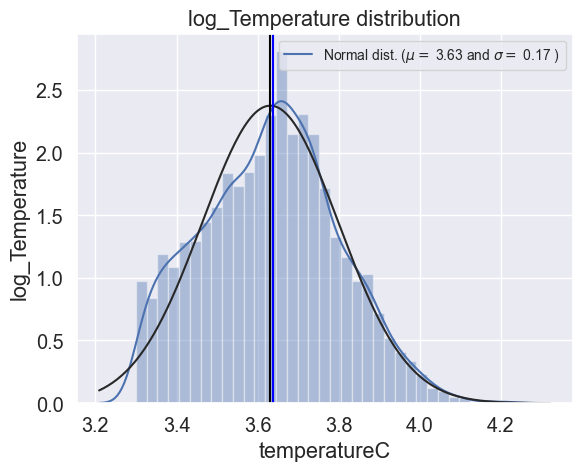

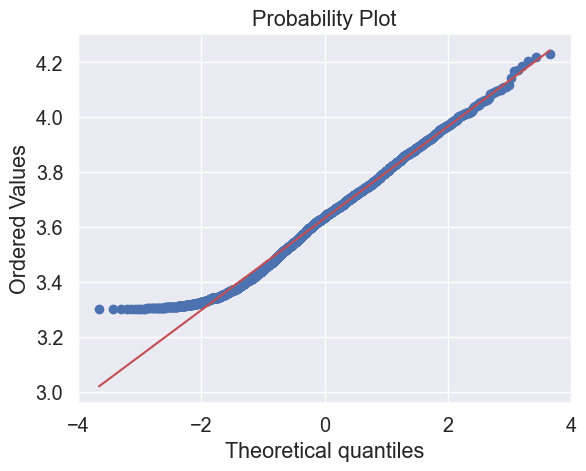

Skewness & Temp: 0.124082
Kurtosis & Temp: -0.428888


In [123]:
log_temp = np.log1p(Temperature)

sns.distplot(log_temp , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_temp)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('log_Temperature')
plt.title('log_Temperature distribution')

## TemperatureRise mean and median value display
plt.axvline(log_temp.mean(), color='black')
plt.axvline(log_temp.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_temp, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % log_temp.skew())
print("Kurtosis & Temp: %f" % log_temp.kurt())

#### log_temp 데이터프레임에 추가하고, feature list 선택하기

In [124]:
AOP_data = AOP_data.assign(log_temp=log_temp)

## 데이터 구분
feature_list = ['probeId', 'roomTempC', 'pulseVoltage', 'numTxCycles', 'numTxElements', 
                'txFrequencyHz', 'elevAperIndex', 'isTxAperModulationEn', 'txpgWaveformStyle', 'pulseRepetRate',
                'scanRange', 'probePitchCm', 'probeRadiusCm', 'probeElevAperCm0', 'probeNumElements', 
                'probeElevFocusRangCm', 'volt2', 'normal_Temp', 'volt_norm', 'Convex',
                'Linear','Phase']

data = AOP_data[feature_list].to_numpy()
target = AOP_data['log_temp'].to_numpy()

In [129]:
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True)

#### 하이퍼파라미터 찾기

In [130]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint


# hyperparameter 세팅 시, 진행.
n_estimators = randint(20, 100)                 ## number of trees in the random forest
max_features = ['auto', 'sqrt']                 ## number of features in consideration at every split
max_depth = [int(x) for x in
             np.linspace(10, 120, num=12)]      ## maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10]                  ## minimum sample number to split a node
min_samples_leaf = [1, 3, 4]                  ## minimum sample number that can be stored in a leaf node
bootstrap = [True, False]                     ## method used to sample data points

param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

# RandomizedSearchCV 객체 생성
model_random = RandomForestRegressor()
random_search = RandomizedSearchCV(model_random, param_distributions=param_dist, n_iter=100, 
                                   cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)


# 하이퍼파라미터 최적화
random_search.fit(train_input, train_target)

# 최적 하이퍼파라미터 출력
print('최적 하이퍼파라미터:', random_search.best_params_)

# 최적 모델 객체 생성
model_best = random_search.best_estimator_

최적 하이퍼파라미터: {'bootstrap': False, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 57}


In [131]:
scores = cross_validate(model_best, train_input, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_best.fit(train_input, train_target)
test_prediction = model_best.predict(test_input)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(np.expm1(test_target), np.expm1(test_prediction))
print(f'|(타깃 - 예측값)|: {mae:.3f}')


{'fit_time': array([1.67853951, 1.56453085, 1.57353854, 1.60854316, 1.56853771]), 'score_time': array([0.04200292, 0.03400111, 0.03800392, 0.03899717, 0.04000115]), 'test_score': array([-0.05540998, -0.0593994 , -0.06292547, -0.05314833, -0.05310282]), 'train_score': array([-3.00684807e-15, -3.01402567e-15, -3.01744719e-15, -3.02157989e-15,
       -3.03990647e-15])}
Train RMSE: 0.000
train_val RMSE: 0.057
Test RMSE: 0.003
|(타깃 - 예측값)|: 1.443


---
### XGboost 모델 이용하기 with 하이퍼 파라미터

In [134]:
import xgboost as xgb
from scipy.stats import uniform, randint


# 하이퍼파라미터 공간 정의
max_depth = [int(x) for x in np.linspace(3, 10, num=8)]  # 적절한 범위로 수정
n_estimators = randint(100, 1000)  # 트리 개수 범위 수정
learning_rate = uniform(0.01, 0.3)  # 학습률 범위
gamma = uniform(0, 0.5)
min_child_weight = [1, 3, 5]
max_delta_step = [1, 3, 5, 7, 9]
subsample = uniform(0.5, 1)
colsample_bytree = uniform(0.5, 1)  
reg_alpha = [0, 0.1, 1, 10]  # L1 정규화 계수
reg_lambda = [0, 0.1, 1, 10]  # L2 정규화 계수


param_dist = {
    'max_depth': max_depth,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'gamma': gamma,
    'min_child_weight': min_child_weight,
    'max_delta_step': max_delta_step,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'reg_alpha': reg_alpha,
    'reg_lambda': reg_lambda
}


# XGBRegressor 객체 생성
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist,
                                   n_iter=100, cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1, verbose=2)


# 하이퍼파라미터 최적화
random_search.fit(train_input, train_target)


# 최적 하이퍼파라미터 출력
print('최적 하이퍼파라미터:', random_search.best_params_)


# 최적 모델 객체 생성
model_best = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


최적 하이퍼파라미터: {'colsample_bytree': 0.6206703307491014, 'gamma': 0.028891028524035522, 'learning_rate': 0.22168321124349405, 'max_delta_step': 5, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 720, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8334568925570387}


In [135]:
scores = cross_validate(model_best, train_input, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_best.fit(train_input, train_target)
test_prediction = model_best.predict(test_input)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(test_target, test_prediction)
print(f'|(타깃 - 예측값)|: {mae:.3f}')


{'fit_time': array([1.22919655, 1.21219826, 1.21519923, 1.22014356, 1.19119859]), 'score_time': array([0.02085114, 0.02094913, 0.02585244, 0.01890755, 0.02694535]), 'test_score': array([-1.80947562, -1.76408749, -1.76591462, -1.63258425, -1.68334678]), 'train_score': array([-0.43846045, -0.4481409 , -0.42754679, -0.44176558, -0.45013995])}
Train RMSE: 0.441
train_val RMSE: 1.731
Test RMSE: 2.312
|(타깃 - 예측값)|: 1.123


In [6]:
if __name__ == '__main__':
    DPP = Data_Preprocess(case='model_fit')
    AOP_data = DPP._sql_get()
    ##### in progress #####
    ## AOP_data라는 데이터가 있을 경우, SQL에서 데이터를 읽어오지 않기  

kr001s1804srv
['Griffin_r01', 'Frosk_r03', 'New_Trees', 'LEO_4port_r01_AutoReport', 'FROSK_r01_AutoReport', 'FROSK_r02_new']
---------------
connect: Griffin_r01
Data 갯수: 2754
---------------
connect: Frosk_r03
Data 갯수: 875
---------------
connect: New_Trees
Data 갯수: 257
---------------
connect: LEO_4port_r01_AutoReport
Data 갯수: 1221
---------------
connect: FROSK_r01_AutoReport
Data 갯수: 491
---------------
connect: FROSK_r02_new
Data 갯수: 118
